# Application of Regression Analysis on SARS-CoV-2 RNA concentrations measured in NYC Wastewater

#### Dylan K. Picart

### Objective 

Using a JSON dataset that contains insightful health metrics, build an API, extract and format data in a database and table, and build a machine learning model that predicts the future trends of SARS-CoV-2, and by extension COVID-19 cases in NYC.

### Sourcing Data
I will be using a Dataset from NYC OpenData to predict future covid wastewater trends and examine how they relate to case rates. This data is from the Department of Health and Mental Hygiene (DOHMH) in New York City.

Source: 
https://data.cityofnewyork.us/Health/SARS-CoV-2-concentrations-measured-in-NYC-Wastewat/f7dc-2q9f

#### Context
The analysis of this project covered the time period of 2020 - 2021. Data is updated monthly. Results of sampling to determine the SARS-CoV-2 N gene levels in NYC DEP Wastewater Resource Recovery Facility (WRRF) influent, disaggregated by the WRRF where the sample was collected, date sample was collected, and date sample was tested. This data contains sampling from multiple locations throughout NYC, and is appropriately labeled.

**Important Note:** While SARS-CoV-2 is the virus that causes COVID-19, SARS-CoV-2 concentrations in wastewater are not the same as COVID-19 Case Rates and should be treated separately. In this project, I explore the commonalities between the infectious cases reported in media and the amount of gene levels prevalent in the wastewater. RT-qPCR was changed to digital PCR in April of 2023, resulting values are about 10-20 times higher than those of RT-qPCR. Please refer to the supporting documentation for more technical information.

##### Useful Libraries

In [48]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import json

## API Access & Building
---

First, we will establish our API connection to source the data.

In [49]:
from requests.exceptions import ConnectionError, HTTPError

api_request_count = 0  # Initialize counter
# Let's create our response r
try:
    r = requests.get('https://data.cityofnewyork.us/resource/f7dc-2q9f.json?$limit=5684')
    r.raise_for_status()
    r.json() # Decode into Python object - note we can easily print an attribute, ie: print(r.json()['copies_l'])
    # Enable raising errors for all error status_codes
    print(r.status_code)
    api_request_count += 1  # Increment after a successful request
    # Intercept the error
except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')
    # Intercept the connection error
except ConnectionError as conn_err:
    print(f'Connection Error! {conn_err}.')

# print(r.json())
print(f"API requests made: {api_request_count}")

200


The following approach is useful for finding the max keys in the JSON, and hopefully therefore all the keys in the JSON.

Note this will not work if some dictionaries have different keys. For example:
```
stuff = [{'fruit': 'apple',
          'sweet': 'Y'},
         {'vegetable': 'parsnip',
          'sweet': 'Y'}]
```

The above has 3 keys, but the most we would find is if we use the below method. However for the sake of this example, we can utilize this approach.

`max(range(len(json_data)), key=lambda i: len(json_data[i]))`

Let's see if we can do the same without relying on the guess that one of the dictionaries contain all keys.

`unique_keys = set(key for d in r.json() for key in d.keys())`

This approach is cleaner and can be applied more broadly, however it is less efficient than the former as there is a higher time complexity `O(n*m)`, where *n* is the number of dictionaries and *m* is the average number of keys in the dictionary. In this case, the more efficient method would be to use the former, which has an time complexity of `O(n+m_max)`, where *m_max* is the number of keys in the dictionary with the most keys. For both, the space complexity is `O(k)`, where *k* is the number of unique keys.

That said, instead of one or the other, we can build a function that does both.

In [50]:
def find_unique_keys(json_data):

  # Find the index of the dictionary with the most keys
  index_with_most_keys = max(range(len(json_data)), key=lambda i: len(json_data[i]))

  # Initialize a set with keys from the dictionary with the most keys
  unique_keys = set(json_data[index_with_most_keys].keys())

  # Iterate through all dictionaries to ensure all unique keys are captured
  for d in json_data:
    if d.keys():
      unique_keys.update(d.keys())  # Add any new keys to the set

  # Convert the set to a list
  unique_keys_list = list(unique_keys)

  return unique_keys_list

print(find_unique_keys(r.json()))

['copies_l', 'test_date', 'sample_date', 'annotation', 'wrrf_abbreviation', 'copies_l_x_average_flowrate', 'population_served', 'technology', 'wrrf_name']


## DataBase Creation
---
We will be creating a DataBase with this API in order to acces, clean, and apply our data for regression analysis. Since we will be using subsequent DataBase access and manipulation, we will also create a Class `SQLiteDB` in order to more efficiently and safely execute code functions.

In [51]:
from sqlite3 import Error
# Let's create a decorator to handle database operation errors
def safe_db_operation(func):
    # Wrapper function to execute the decorated function and handle exceptions
    def wrapper(db_instance, *args, **kwargs): # Nested function takes a db_instance (presumably an instance of a database connection or object), along with any positional arguments (*args) and keyword arguments (**kwargs) that the original decorated function might accept.
        try:
            # Execute the decorated function and store the result
            result = func(db_instance, *args, **kwargs) #  calls the original decorated function (func) with the provided arguments. This line attempts to execute the database operation. The result of the operation, if successful, is stored in the result variable.
            # Return the result if successful
            return result
        except Error as e:
            print(f"Database operation failed: {e}")
        # Return None if an exception occurs
        return None # if an exception occurred and was caught in the except block, this line returns None
    return wrapper

In [52]:
# SQLiteDB class with context manager
class SQLiteDB:
    def __init__(self, db_file):
        """Initialize with the database file."""
        self.db_file = db_file # Assign input to instance variable
        self.con = None # Set instance variable named con to None. Later to be stored as DB connection object

    def connect(self):
        """Create a database connection."""
        try:
            self.con = sqlite3.connect(self.db_file) # Attempts to connect to self.db_file and assigns connection object to self.con
            print(f"Connected to database: {self.db_file}") # Prints a success message if the connection is established
        except Error as e:
            print(f"Error connecting to database: {e}")


    def close(self):
        """Ensure the connection is closed properly."""
        if self.con: # Checks if a database connection (self.con) exists.
            self.con.close() # If a connection exists, closes it to release resources and ensure proper database handling
            print("Connection closed.") # Prints a message indicating that the connection has been closed


    def __enter__(self):
        """Open the connection when entering the context."""
        self.connect() # Calls the connect method to establish a database connection.
        return self # Returns the instance of the class (self)

    def __exit__(self, exc_type, exc_value, traceback):
        """Close the connection when exiting the context."""
        self.close() # Calls the close method to ensure the database connection is closed properly
        if exc_type is not None: # Checks if an exception occurred within the with block.
            print(f"Exception: {exc_value}") # If an exception occurred, prints the exception value.
        return False # Returns False to indicate that the exception, if any, was not handled within this method.

    @safe_db_operation
    def execute_query(self, query, params=None):
        """Execute a query and return the result."""
        cur = self.con.cursor() # Changed cur() to cursor()
        if params: # Checks if parameters (params) are provided for the query
            cur.execute(query, params) # If parameters are provided, executes the query with the parameters.
        else:
            cur.execute(query) # If no parameters are provided, executes the query without parameters
        self.con.commit() # Commits the changes made by the query to the database.
        return cur.fetchall() # Returns all rows fetched by the query as a list of tuples.

    @safe_db_operation
    def execute_many(self, query, param_list):
        """Execute a query with multiple sets of parameters."""
        cur = self.con.cursor()

        # Extract the table name from the query
        table_name = query.split(' ')[2]  # Assumes the table name is the third word in the query

        # Check if the table is empty
        try:
            cur.execute(f"SELECT COUNT(*) FROM {table_name}")
            if cur.fetchone()[0] == 0:
                cur.executemany(query, param_list)
                self.con.commit()
            else:
                print(f"Error: The table {table_name} is not empty. Values will not be inserted.")
        except sqlite3.OperationalError as e:
            print(f"Error checking table: {e}")  # Handle potential errors if the table doesn't exist

        return None

### Safety

To protect the integrity of our data and limit the need to run an API request, we will create a `raw_json` table to extract our data from.

This table will not be modified and is only there to extract data.

In [ ]:
# To place into a database, let's use list comprehension to convert each row in the r.json() to a string and then tuplefy each row

# json.dumps is the proper way to convert the rows into strings; str() messes up the format
# For safety, SQLite only wants things packed in tuples
# Place a wrapper around the string - can just do (row,) ?
list_of_tuples = [(json.dumps(row),) for row in r.json()] # Encodes a Python object to a JSON string
print(list_of_tuples)

We will use SQLite to begin our Database creation and subsequent manipulation.

In [ ]:
db_file = 'covid_conc_samples.db'

# Let's create a table to store the raw data
create_raw_table_sql = '''
CREATE TABLE IF NOT EXISTS raw_json(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    raw_text TEXT
);
'''

with SQLiteDB(db_file) as db:
    # Create the raw_json table
    db.execute_query(create_raw_table_sql)

    # Insert data using executemany
    db.execute_many('INSERT INTO raw_json (raw_text) VALUES (?)', list_of_tuples)

    # Fetch all data from the table
    raw_text = db.execute_query('SELECT * FROM raw_json')
    print(raw_text)

`cur.executemany()` acts as a for loop .
Similar to:
```
for row in list_of_tuples:
  cur.execute('INSERT INTO raw_json (raw_text) VALUES (?)', row)
```
With `executemany()`, we put in an iterable `list_of_tuples`.


### Task List



1.   Get the data out of the database
2.   Unpack the data
3.   Transform data into a dictionary
4.   Fix the missing values
5.   Create the workable data table
6.   Push data into that table



In [ ]:
# Let's further build out this API to easily access & extract our raw data
# 1. Get data out of the database

def get_raw_data(db_file):
    with SQLiteDB(db_file) as db:
        list_of_rows = db.execute_query('SELECT * from raw_json')
    return list_of_rows

raw_text = get_raw_data('covid_conc_samples.db')

print(raw_text)

In [56]:
# 2. Unpack the data

for row in raw_text:
  # Unpack
  row_id, row_text = row
  row_text = json.loads(row_text) # Decode JSON string into Python object

# # List comprehension version
# row_text = [json.loads(row_text) for row_id, row_text in raw_text]

In [57]:
row_id, row_text = raw_text[29]

# print(row_id, row_text)

# 3. Convert back to dictionary
row_text = json.loads(row_text)
# Then get keys
row_text.keys()

dict_keys(['sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served', 'technology'])

In [59]:
# Let's create a workable data table where we use the key-values we care about

kvs_for_work_table = ['sample_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l',
                       'copies_l_x_average_flowrate', 'population_served']

In [60]:
# This is Pythonic
# list_of_keys = [y for y in r.json()[29].keys()]
# OR
list_of_keys = find_unique_keys(r.json())

# Container for the fixed rows
list_of_dictionaries = []

# 4. Fix the missing values

# list_of_keys are my keys to check against
for key in list_of_keys:
    if key in row_text.keys():
        pass
    else:
      row_text[key] = 'NaN'
list_of_dictionaries.append(row_text)

print(list_of_dictionaries)

[{'sample_date': '2024-08-20T00:00:00.000', 'test_date': '2024-08-22T00:00:00.000', 'wrrf_name': 'Wards Island', 'wrrf_abbreviation': 'WI', 'copies_l': '77600.00', 'copies_l_x_average_flowrate': '51800000', 'annotation': 'This sample was analyzed in duplicate.', 'population_served': '1173448', 'technology': 'dPCR-SC2'}]


In [61]:
print(list_of_keys)

['copies_l', 'test_date', 'sample_date', 'annotation', 'wrrf_abbreviation', 'copies_l_x_average_flowrate', 'population_served', 'technology', 'wrrf_name']


`data_extractor()` extracts the data from our raw data table that is in the form of a list of tuples and JSONifies it. This will make it easier to manipulate the data before loading it into our working table.

In [62]:
def data_extractor(list_of_tuples, list_of_keys):
    """
    Extracts data from list of tuples made from raw data and 
    converts to JSON format using a list of keys we pass into.


    Parameters
    ----------
    list_of_tuples : list
        A list of tuples made from our JSON data
    list_of_keys : list
        A list of dictionary keys taken from our JSON data

    Returns
    -------  
     list_of_relevant_info : list 
        JSONified data
    """
    
    # Create empty list to store unpacked dictionaries
    list_of_relevant_info = []
    # Extract json from tuple pair by unpacking
    # x: id, y: {raw_json}
    for x, y in list_of_tuples:
        # Set up a temporary dictionary to hold pruned k-v pairs- it's reset on every iterative loop
        temp_dict = {}
        # We need to jsonify our string
        parsed_json = json.loads(y)
        # Iterate over the key-value pairings in our dictionary
        # Unpack the JSON, storing keys in k, values in v
        # Only want to retain the key-values I care about
        for k, v in parsed_json.items():
            # Check if it matches the string in the list_of_keys
            if k in list_of_keys:
                # If it matches, store the key-value pairing
                temp_dict[k] = v
            # Append to the list & do this for every k-v pairings that match
        list_of_relevant_info.append(temp_dict)
    return list_of_relevant_info

In [ ]:
y = data_extractor(raw_text, row_text.keys())
print(y)

In [65]:
kvs_to_delete = ['test_date', 'annotation', 'technology']

`column_deleter()` is useful in deleting columns that you don't want in your SQL DataBase. It returns a cleaned JSON format.

In [66]:
def column_deleter(list_of_dicts, kvs_to_get_rid_of):
    """_summary_

    Args:
        list_of_dicts (_type_): _description_
        kvs_to_get_rid_of (_type_): _description_

    Returns:
        _type_: _description_
    """
    cleaned_dicts = []
    for row in list_of_dicts:
        temp_dict = {}
        for key in row.keys():
            if key in kvs_to_get_rid_of:
                pass
            else:
                temp_dict[key] = row[key]
        cleaned_dicts.append(temp_dict)
    return cleaned_dicts

workable_lod = column_deleter(y, kvs_to_delete)
# Use index with the max keys to test if it worked
print(workable_lod[29])

{'sample_date': '2024-08-20T00:00:00.000', 'wrrf_name': 'Wards Island', 'wrrf_abbreviation': 'WI', 'copies_l': '77600.00', 'copies_l_x_average_flowrate': '51800000', 'population_served': '1173448'}


`data_converter()` takes the JSONified data and

In [67]:
# This is merely to keep the order of the features
work_keys = ['sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l', 'copies_l_x_average_flowrate', 'annotation', 'population_served', 'technology']

def data_converter(json_data, keys_I_care_about):
    '''
    Takes in a list of dictionaries, unpacks it, fills in missing values with NaN, and converts to list of tuples
    Args:
        json_data (list(dict)) -
        keys_I_care_about (list(str)) -
    Returns:
        list_of_tup_dicts (list(tuple)) -
    '''

    list_of_tup_dicts = []

    # Process each entry in the raw data
    for row in json_data:
        a, b = row  # Unpack the tuple

        # Convert the JSON string values to a dictionary
        b = json.loads(b)

        # Create a tuple with values in the exact order specified by keys_I_care_about
        tuple_to_add = tuple(b.get(key, 'NaN') for key in keys_I_care_about)

        # Append the correctly ordered tuple to the list
        list_of_tup_dicts.append(tuple_to_add)

    return list_of_tup_dicts


# Moving this to another cell messes up the order
# Call the function with the sample data
values_of_keys = data_converter(raw_text, work_keys)

# Print the output for verification
print(values_of_keys[29])

('2024-08-20T00:00:00.000', '2024-08-22T00:00:00.000', 'Wards Island', 'WI', '77600.00', '51800000', 'This sample was analyzed in duplicate.', '1173448', 'dPCR-SC2')


### Workable DataBase

Let's create our table we will use to modify our data.

In [68]:
create_work_table_sql = ''' CREATE TABLE IF NOT EXISTS work_data(
                            id INTEGER PRIMARY KEY AUTOINCREMENT,
                            sample_date DATETIME,
                            test_date DATETIME,
                            wrrf_name TEXT,
                            wrrf_abbreviation TEXT,
                            copies_l REAL,
                            copies_l_x_average_flowrate INTEGER,
                            annotation TEXT,
                            population_served INTEGER,
                            technology TEXT);'''

In [ ]:
with SQLiteDB(db_file) as db:
    # Create the work_data table
    db.execute_query(create_work_table_sql)

    # Insert data using executemany
    db.execute_many('INSERT INTO work_data (sample_date, test_date, wrrf_name, wrrf_abbreviation, copies_l, \
                copies_l_x_average_flowrate, annotation, population_served, technology) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);', values_of_keys)
    
    # Fetch all data from the table
    work_data = db.execute_query('SELECT * FROM work_data;')
    print(work_data)

    # work_data is a list of tuples, convert to DataFrame and assign column names
    work_table = pd.DataFrame(work_data, columns=['id', 'sample_date', 'test_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l',
                                                  'copies_l_x_average_flowrate', 'annotation', 'population_served', 'technology'])
work_table.head()

## Helper Functions
---

Next let's create some helper functions so access the table in Python

In [70]:
# Drop columns from work_data table
columns_to_drop = ('test_date', 'annotation', 'technology')
# Iterate over the columns you want to drop and execute individual ALTER TABLE statements
# Iterate over the columns and execute individual ALTER TABLE statements
with SQLiteDB(db_file) as db:
  for col in columns_to_drop:
    db.execute_query(f'ALTER TABLE work_data DROP COLUMN {col}')

Connected to database: covid_conc_samples.db
Connection closed.


In [71]:
# This is how our original work table looks
work_columns = ['id', 'sample_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l',
                'copies_l_x_average_flowrate', 'population_served']

def work_tables():
    with SQLiteDB(db_file) as db:      
      # Fetch all data from the table
      work_data = db.execute_query('SELECT * FROM work_data;')      
      # work_data is a list of tuples, convert to DataFrame and assign column names
      work_table = pd.DataFrame(work_data, columns=['id', 'sample_date', 'wrrf_name', 'wrrf_abbreviation', 'copies_l',
                                                    'copies_l_x_average_flowrate', 'population_served'])
    return work_table.head()

work_tables()

Connected to database: covid_conc_samples.db
Connection closed.


,id,sample_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,population_served
0,1,2024-08-27T00:00:00.000,26th Ward,26W,34080.0,NaN,318262
1,2,2024-08-27T00:00:00.000,Bowery Bay,BB,49931.43,NaN,894311
2,3,2024-08-27T00:00:00.000,Coney Island,CI,NaN,NaN,647635
3,4,2024-08-27T00:00:00.000,Hunts Point,HP,51257.14,NaN,781885
4,5,2024-08-27T00:00:00.000,Jamaica Bay,JA,58845.71,NaN,735054


### Data Cleaning & Wrangling

In order to run our Regression Analysis, we need to clear out our NaN values. The helper functions we establish will help in formatting the data in an easier fahion. 

In [72]:
# Let's delete the NaN values
with SQLiteDB(db_file) as db:
  db.execute_query('DELETE FROM work_data WHERE copies_l = ?', ('NaN',))

Connected to database: covid_conc_samples.db
Connection closed.


In [73]:
# Check
with SQLiteDB(db_file) as db:
  na_copies = db.execute_query('SELECT * FROM work_data WHERE copies_l = ?', ('NaN',))
  na_cop = pd.DataFrame(na_copies, columns=work_columns).head()
na_cop

Connected to database: covid_conc_samples.db
Connection closed.


,id,sample_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,population_served


NaN values for `copies_l` exist typically due to the concentration being below the limit of detection. Other reasons include analytical errors. While it unwise to not include NaN values for it being too small for measurable methods to detect, for the sake of simplification we will focus on the measured values to make our analysis

In [74]:
# To ensure copies_l_avgflowrate NaN values in the same rows as copies_l
with SQLiteDB(db_file) as db:
  copies_avg = db.execute_query('SELECT * FROM work_data WHERE copies_l_x_average_flowrate = ?', ('NaN',))
  cop_avg = pd.DataFrame(copies_avg, columns=work_columns).head()
cop_avg

Connected to database: covid_conc_samples.db
Connection closed.


,id,sample_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,population_served
0,1,2024-08-27T00:00:00.000,26th Ward,26W,34080.00,NaN,318262
1,2,2024-08-27T00:00:00.000,Bowery Bay,BB,49931.43,NaN,894311
2,4,2024-08-27T00:00:00.000,Hunts Point,HP,51257.14,NaN,781885
3,5,2024-08-27T00:00:00.000,Jamaica Bay,JA,58845.71,NaN,735054
4,6,2024-08-27T00:00:00.000,Newtown Creek,NC,37714.29,NaN,1227810


Later we can drop the NaN values in the `copies_l_x_average_flowrate` and run an analysis on either both `copies_l` and `copies_l_x_average_flowrate` or exclusively the latter.

In [75]:
def select_by_abv_loc(wrrf_abrv):
  with SQLiteDB(db_file) as db:
    return db.execute_query("SELECT * FROM work_data WHERE wrrf_abbreviation = ?", (wrrf_abrv,))

In [76]:
def select_by_sample_month(start, end):
  with SQLiteDB(db_file) as db:
    return db.execute_query("SELECT * FROM work_data WHERE sample_date BETWEEN ? AND ?", (start, end))

This table will contain of NYC's testing data for Fall 2020 - Summer 2021

In [77]:
nyc_data_20_21 = pd.DataFrame(select_by_sample_month('2020-09-01T00:00:00.000', '2021-07-01T00:00:00.000'), columns=work_columns)
nyc_data_20_21.drop(columns=['id'], inplace=True)
nyc_data_20_21.index = nyc_data_20_21.index + 1
nyc_data_20_21

Connected to database: covid_conc_samples.db
Connection closed.


,sample_date,wrrf_name,wrrf_abbreviation,copies_l,copies_l_x_average_flowrate,population_served
1,2021-06-29T00:00:00.000,Oakwood Beach,OB,11096.29,4090000,243910
2,2021-06-29T00:00:00.000,Wards Island,WI,1285.05,1040000,1173448
3,2021-06-29T00:00:00.000,Tallman Island,TI,2443.81,1030000,457817
4,2021-06-29T00:00:00.000,Rockaway,RK,416.76,262000,117991
5,2021-06-29T00:00:00.000,Red Hook,RH,523.27,265000,257556
...,...,...,...,...,...,...
956,2020-09-06T00:00:00.000,North River,NR,282.30,137000,649549
957,2020-09-06T00:00:00.000,Newtown Creek,NC,365.23,194000,1227810
958,2020-09-06T00:00:00.000,Jamaica Bay,JA,437.35,159000,735054
959,2020-09-02T00:00:00.000,Red Hook,RH,241.52,97900,257556


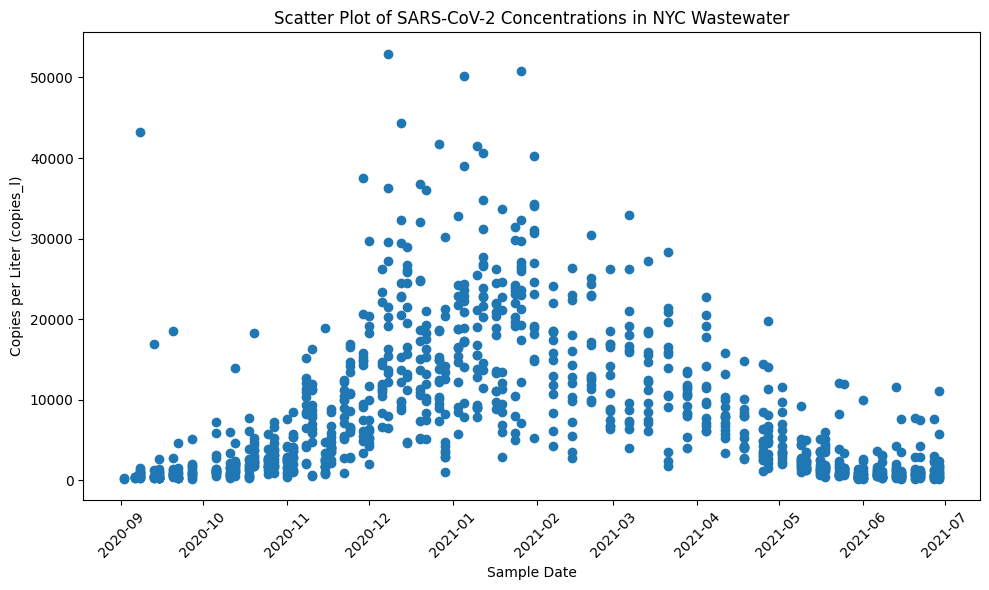

In [78]:
# Convert 'sample_date' to datetime objects
nyc_data_20_21['sample_date'] = pd.to_datetime(nyc_data_20_21['sample_date'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nyc_data_20_21['sample_date'], nyc_data_20_21['copies_l'])
plt.xlabel('Sample Date')
plt.ylabel('Copies per Liter (copies_l)')
plt.title('Scatter Plot of SARS-CoV-2 Concentrations in NYC Wastewater')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The function `generate_monthly_dataframes()` will be useful in creating a series of dataframes to analyze from a month to month basis.

In [79]:
from datetime import datetime, timedelta

def generate_monthly_dataframes(start_date, end_date):
    """
    Generates a list of DataFrames for each month between the start and end dates.

    Parameters:
    start_date (str): The start date in the format 'YYYY-MM-DD'.
    end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
    dict: A dictionary where keys are month names, and values are DataFrames for each month.
    """
    # Convert the start and end dates to datetime objects
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    # List of column names to assign to each dataframe
    month_cols = ['id', 'sample_date', 'wrrf_name', 'wrrf_abbreviation',
                  'copies_l', 'copies_l_x_average_flowrate', 'population_served']

    # Initialize a dictionary to store DataFrames for each month - Key: month, Value: corresponding DF
    monthly_dataframes = {}

    with SQLiteDB(db_file) as db:  # Establish connection here

        # Generate DataFrames for each month
        while current_date < end_date:
            # Calculate the start and end of the month
            next_month = (current_date.replace(day=28) + timedelta(days=4)).replace(day=1)
            month_name = current_date.strftime("%b").lower()  # e.g., 'sep', 'oct'

            # Fetch data for the current month using the helper function
            df = pd.DataFrame(db.execute_query("SELECT * FROM work_data WHERE sample_date BETWEEN ? AND ?", (current_date.isoformat(), next_month.isoformat())), columns=month_cols)

            # Store the DataFrame in the dictionary
            monthly_dataframes[month_name] = df

            # Move to the next month
            current_date = next_month

    return monthly_dataframes

In [80]:
'''
THIS IS WRONG IF WE WANT TO CREATE A DATAFRAME RANGE - SHOULD CREATE DATAFRAME FOR RANGE OF MONTHS, NOT JUST SEP1-SEP30
WE CAN OVERCOME BY CONCATING ALL DFs
'''

# Month DataFrame from 2020 - 2021
mdf_20_21 = generate_monthly_dataframes('2020-09-01', '2021-07-01')

# Create our DataFrames containing the data from September to June
sep_2020, oct_2020, nov_2020, dec_2020 = mdf_20_21['sep'], mdf_20_21['oct'], mdf_20_21['nov'], mdf_20_21['dec']
jan_2021, feb_2021, mar_2021 = mdf_20_21['jan'], mdf_20_21['feb'], mdf_20_21['mar']
apr_2021, may_2021, jun_2021 = mdf_20_21['apr'], mdf_20_21['may'], mdf_20_21['jun']

# print(sep_2020) # Check by printing

Connected to database: covid_conc_samples.db
Connection closed.


In [81]:
# Helper function to select a specific location by month
def select_loc_and_mo(abv, start, end):
  with SQLiteDB(db_file) as db:
    return db.execute_query('SELECT * FROM work_data WHERE wrrf_abbreviation = ? AND sample_date BETWEEN ? AND ?', (abv, start, end,))

In [82]:
def generate_location_and_time_df(abbreviations, start_date, end_date):
    """
    Generates a list of DataFrames for each location abbreviation within a specific date range.

    Parameters:
    abbreviations (list of str): List of location abbreviations.
    start_date (str): The start date in the format 'YYYY-MM-DD'.
    end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
    dict: A dictionary where keys are location abbreviations with a time range,
          and values are DataFrames for each location within that time range.
    """
    # Initialize a dictionary to store DataFrames for each location
    location_dataframes = {}

    # Convert the start and end dates to datetime objects
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d")
    end_datetime = datetime.strptime(end_date, "%Y-%m-%d")

    # Format the year range for the dictionary keys (e.g., '20_21' for 2020-2021)
    year_range = f"{start_datetime.strftime('%y')}_{end_datetime.strftime('%y')}"

    # Initialize an empty DataFrame for each location abbreviation
    for abbr in abbreviations:
        location_dataframes[abbr.lower() + '_' + year_range] = pd.DataFrame()

    with SQLiteDB(db_file) as db:
        # Generate DataFrames for each location and time period
        current_date = start_datetime
        while current_date < end_datetime:
            # Calculate the start and end of the current month
            next_month = (current_date.replace(day=28) + timedelta(days=4)).replace(day=1)

            # Iterate over each location abbreviation
            for abbr in abbreviations:
                # Fetch data for the current location and month using the helper function
                df = pd.DataFrame(db.execute_query('SELECT * FROM work_data WHERE wrrf_abbreviation = ? AND sample_date BETWEEN ? AND ?', (abbr, current_date.isoformat(), next_month.isoformat())))

                # Rename the columns of the DataFrame
                if not df.empty:
                    df.columns = ['id', 'sample_date', 'wrrf_name', 'wrrf_abbreviation',
                                'copies_l', 'copies_l_x_average_flowrate', 'population_served']

                    # Append the monthly data to the corresponding location's cumulative DataFrame
                    location_dataframes[abbr.lower() + '_' + year_range] = pd.concat(
                        [location_dataframes[abbr.lower() + '_' + year_range], df], ignore_index=True
                    )

            # Move to the next month
            current_date = next_month

    return location_dataframes

In [83]:
abbreviations = ['26W', 'BB', 'CI', 'HP', 'JA', 'NC', 'NR', 'OB', 'OH', 'PR', 'RH', 'RK', 'TI', 'WI']
location_dataframes = generate_location_and_time_df(abbreviations, '2020-09-01', '2021-07-01')

# Accessing dataframes by location and time range
w26_20_21, bb_20_21, ci_20_21, hp_20_21 = location_dataframes['26w_20_21'], location_dataframes['bb_20_21'], location_dataframes['ci_20_21'], location_dataframes['hp_20_21']
ja_20_21, nc_20_21, nr_20_21, ob_20_21 = location_dataframes['ja_20_21'], location_dataframes['nc_20_21'], location_dataframes['nr_20_21'], location_dataframes['ob_20_21']
oh_20_21, pr_20_21, rh_20_21, rk_20_21 = location_dataframes['oh_20_21'], location_dataframes['pr_20_21'], location_dataframes['rh_20_21'], location_dataframes['rk_20_21']
ti_20_21, wi_20_21 = location_dataframes['ti_20_21'], location_dataframes['wi_20_21']


# Print an example and shape to show that we have all data points
print(bb_20_21.head(), '\n\n', bb_20_21.shape)

Connected to database: covid_conc_samples.db
Connection closed.
     id              sample_date   wrrf_name wrrf_abbreviation  copies_l  \
0  5572  2020-09-27T00:00:00.000  Bowery Bay                BB   1415.77   
1  5586  2020-09-22T00:00:00.000  Bowery Bay                BB    289.19   
2  5600  2020-09-20T00:00:00.000  Bowery Bay                BB   1425.44   
3  5614  2020-09-15T00:00:00.000  Bowery Bay                BB    971.56   
4  5615  2020-09-13T00:00:00.000  Bowery Bay                BB   1278.41   

   copies_l_x_average_flowrate  population_served  
0                       516000             894311  
1                       107000             894311  
2                       537000             894311  
3                       342000             894311  
4                       471000             894311   

 (68, 7)


## Hypothesis
---
During the height of the COVID-19 pandemic in New York City, we had skyrocketing cases of COVID-19 infections during the winter months, and diminishing cases as we got closer to spring and summertime. While COVID-19 case diagnoses are not the same as SARS-CoV-2 concentrations in wastewater, there is more than likely a correlation between rising cases and the amount of genetic material prevalent in wastewater. As COVID-19 cases rose, so would the concentrations of SARS-CoV-2 detected in wastewater.

To test our hypothesis, we will run Data Visualizations across all areas tested & build a Linear Regression Model to predict the trend of subsequent genetic concentrations in wastewater.

## Regression Analysis
---

### Visualizations for our 14 locations

Let's see what the genetic data looks like through the months of September 2020 - June 2021

In [30]:
font1 = {'family':'serif','color':'navy','size':13}
font2 = {'family':'serif','color':'darkred','size':12}

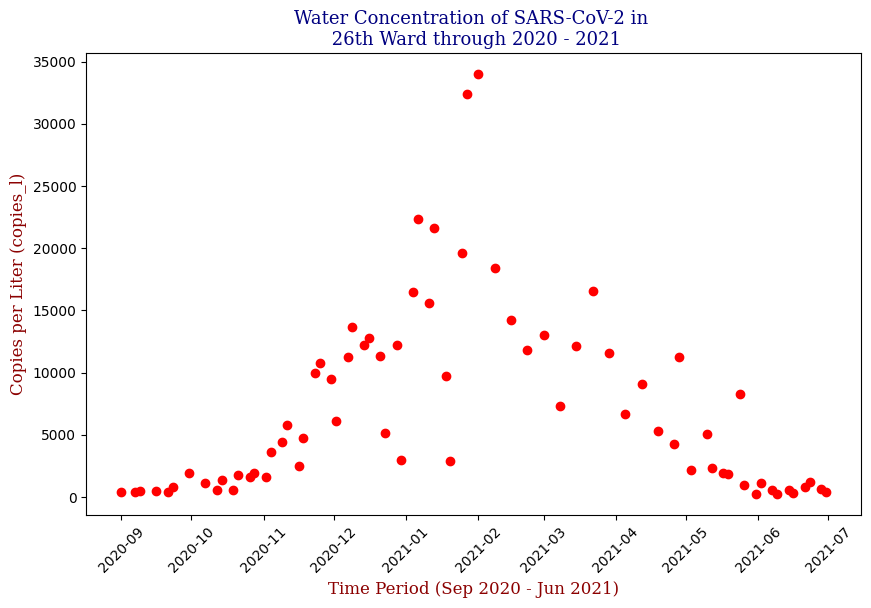

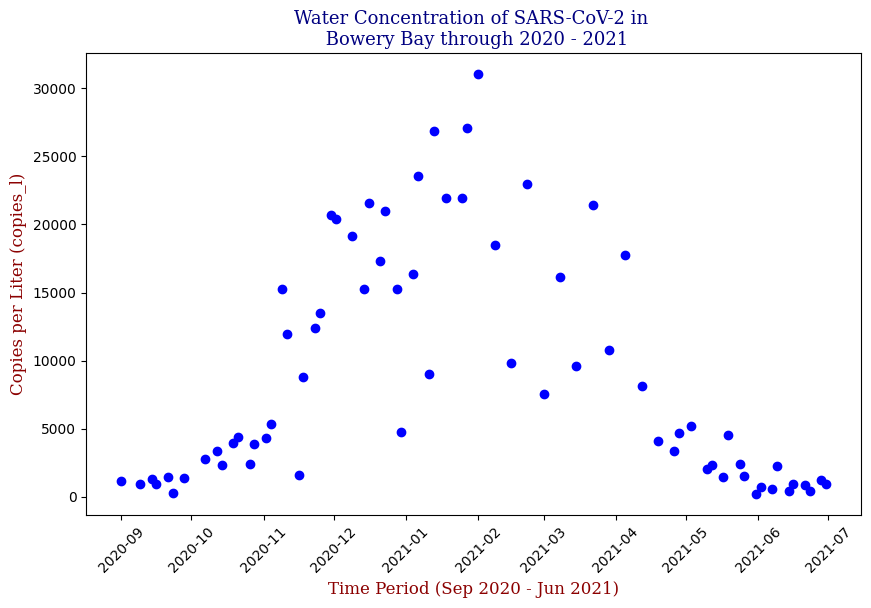

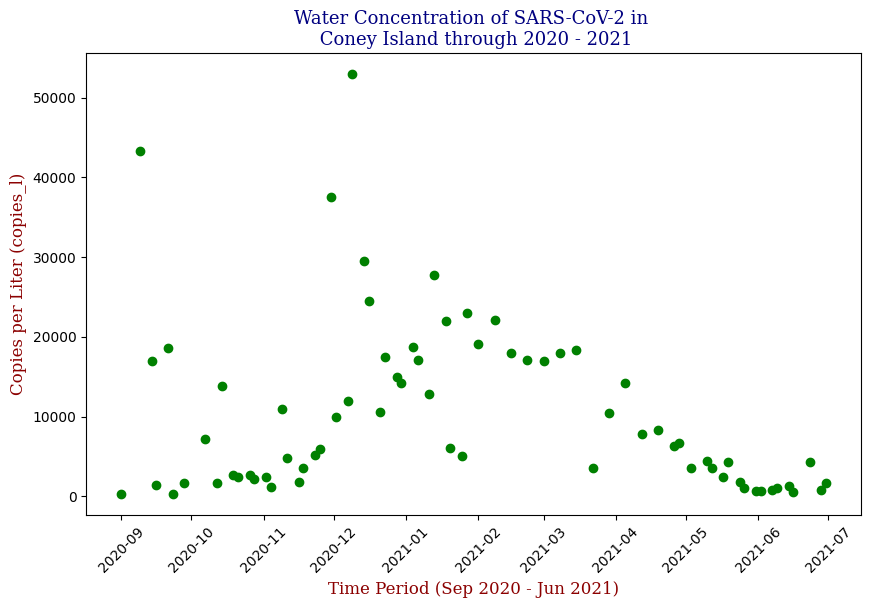

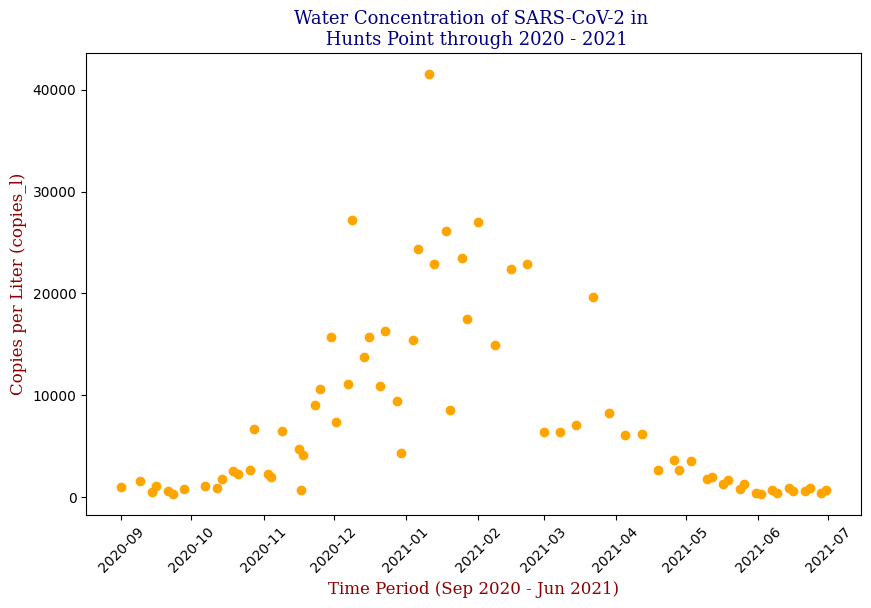

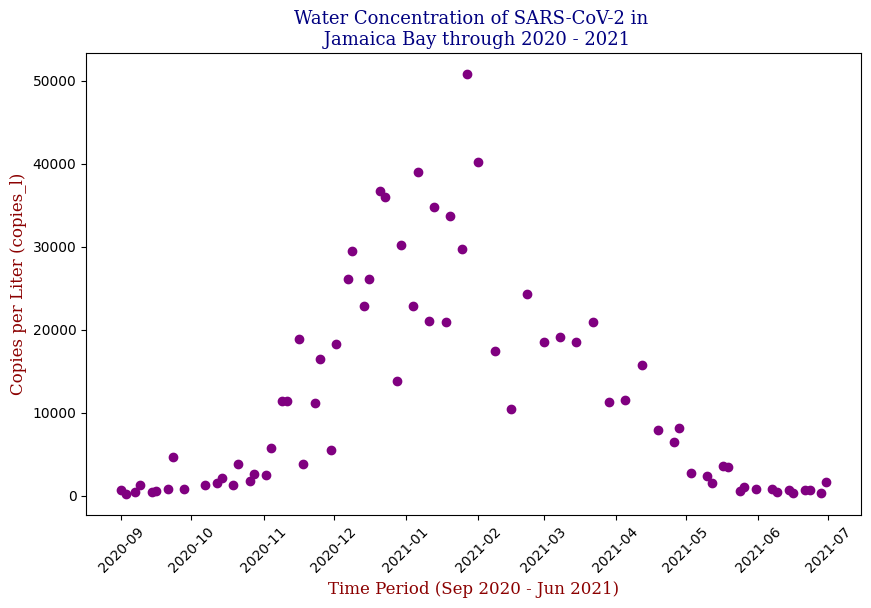

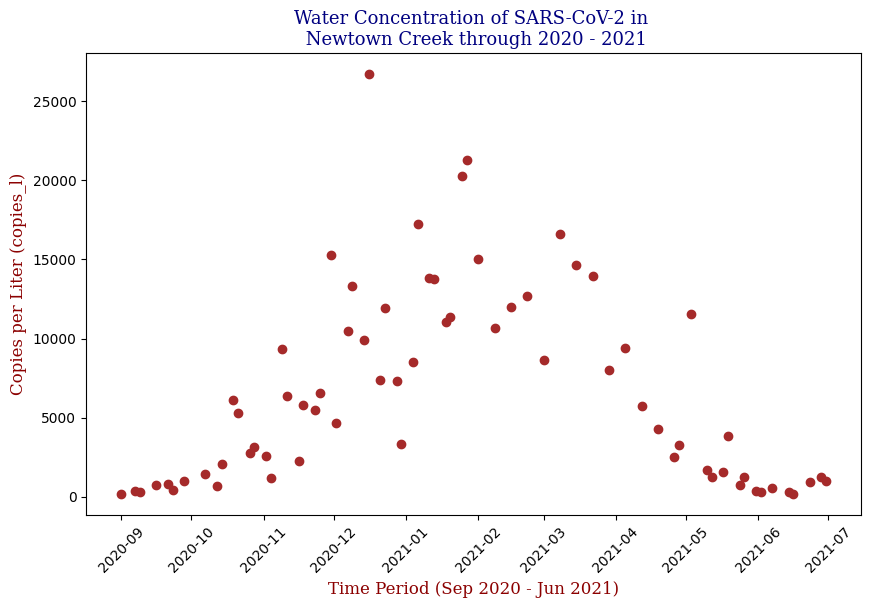

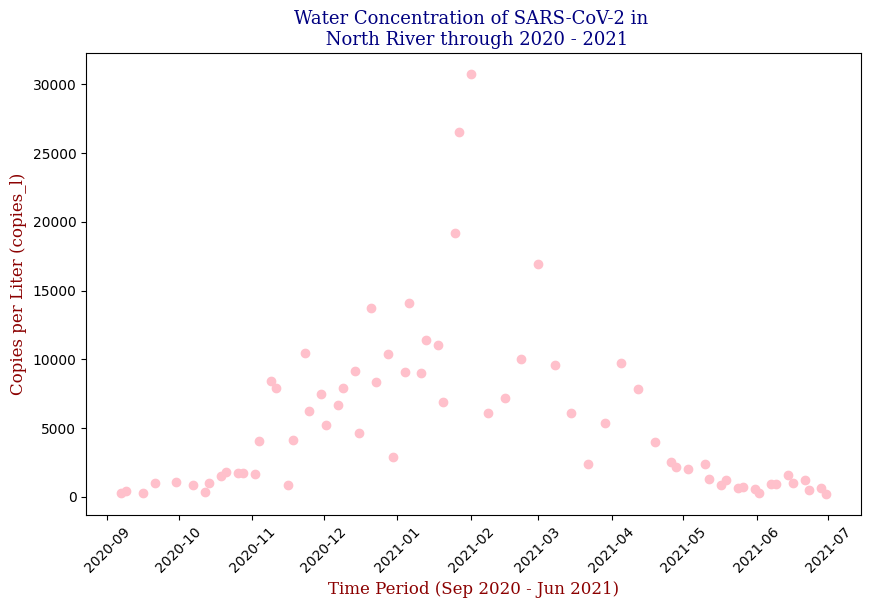

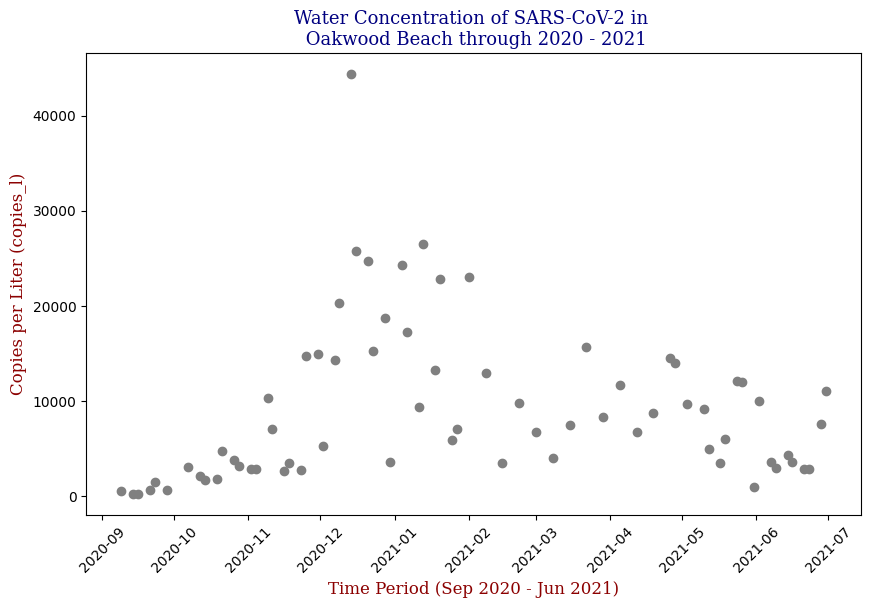

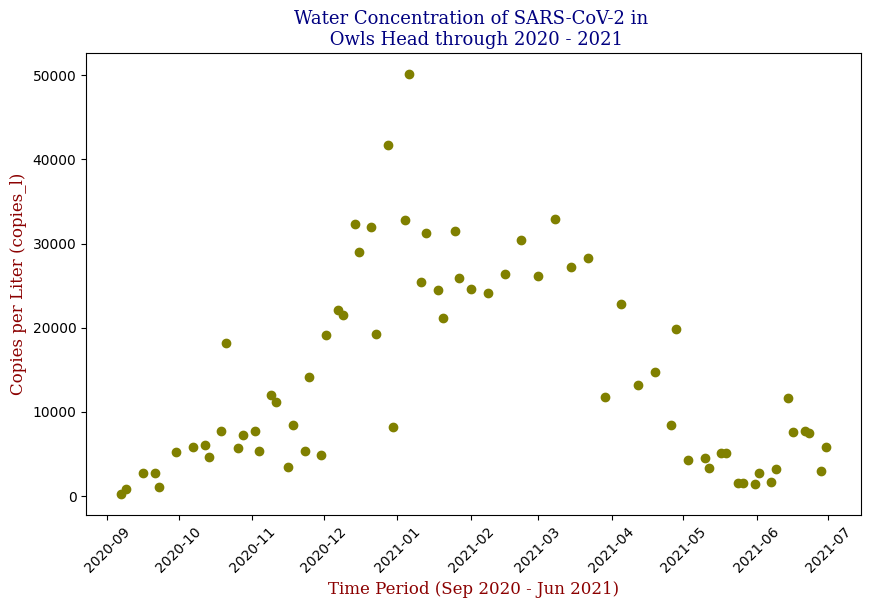

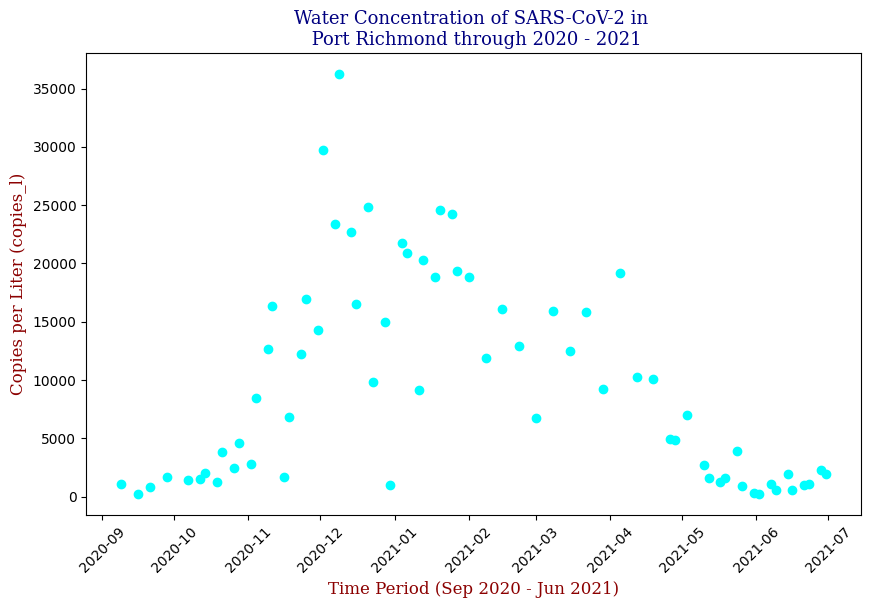

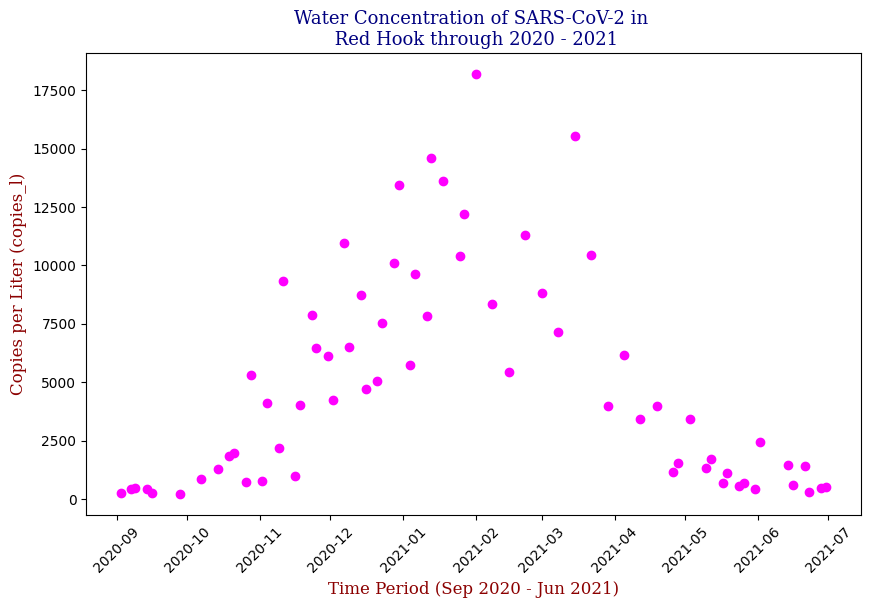

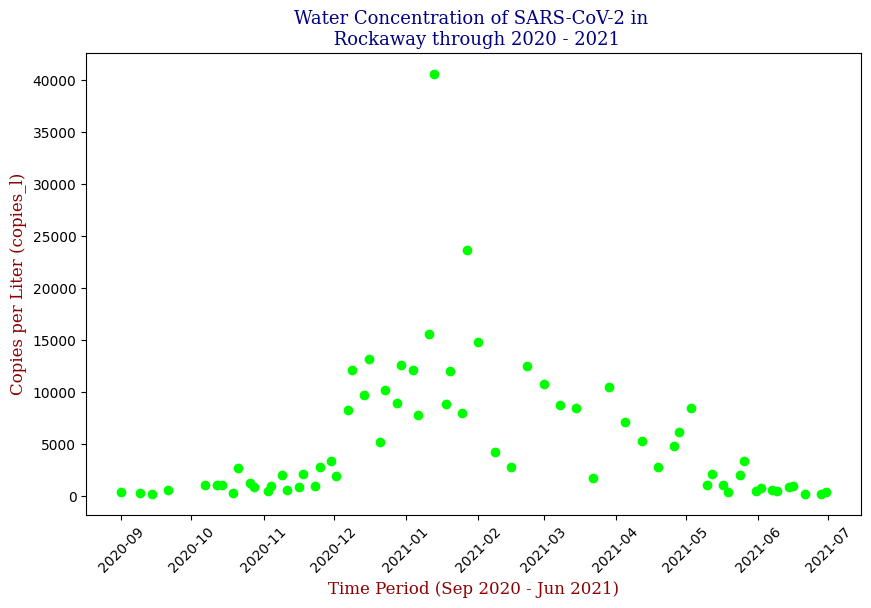

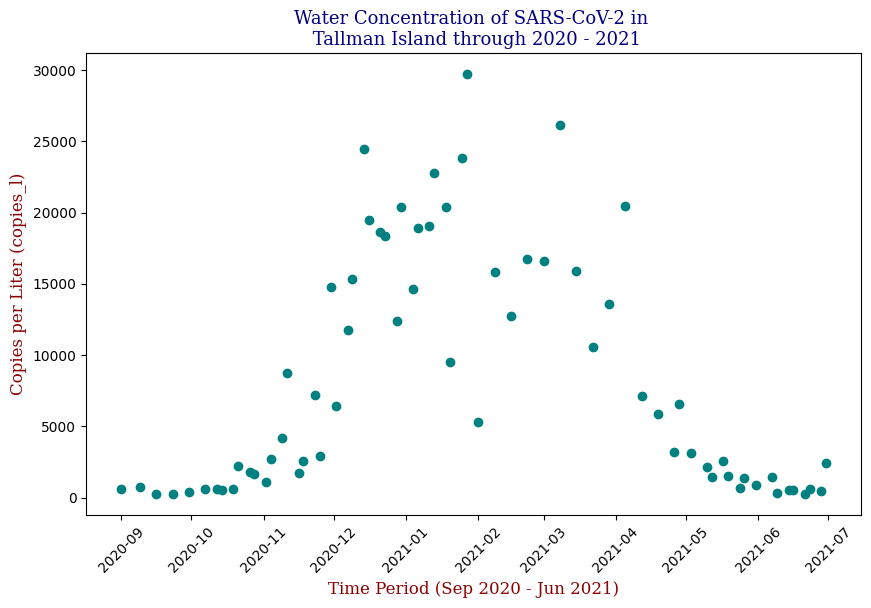

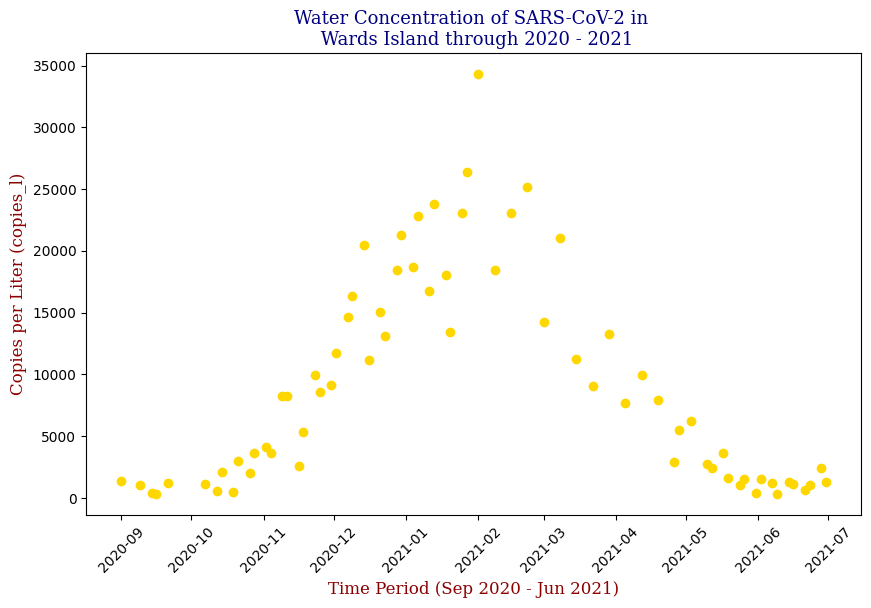

In [31]:
# Let's see what a scatter looks like.
from datetime import datetime

def create_scatter_plots(location_dataframes):
  """
  Creates 14 scatter plots for different locations with specified colors.

  Args:
    location_dataframes: A dictionary containing DataFrames for each location.
  """
  colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink',
            'gray', 'olive', 'cyan', 'magenta', 'lime', 'teal', 'gold']

  for i, (location, df) in enumerate(location_dataframes.items()):
    # Convert 'test_date' to datetime objects
    df['test_date'] = pd.to_datetime(df['test_date'])

    plt.figure(figsize=(10, 6))
    plt.scatter(df['test_date'], df['copies_l'], color=colors[i])
    plt.title(f"Water Concentration of SARS-CoV-2 in \n {df['wrrf_name'].iloc[0]} through 2020 - 2021", fontdict=font1)
    plt.xlabel('Time Period (Sep 2020 - Jun 2021)', fontdict=font2)
    plt.ylabel('Copies per Liter (copies_l)', fontdict=font2)
    # Format x-axis ticks as 'YYYY-MM'
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.show()

# Call the function with the location_dataframes dictionary
create_scatter_plots(location_dataframes)

**Visualization Insight**

From our visualization, we can see that throughout the middle of the time periods (from Dec - Feb), the concentrations of the genetic material was at an all-time high relative to the beginning and end months throughout all locations.

### Regression Model & Evaluation

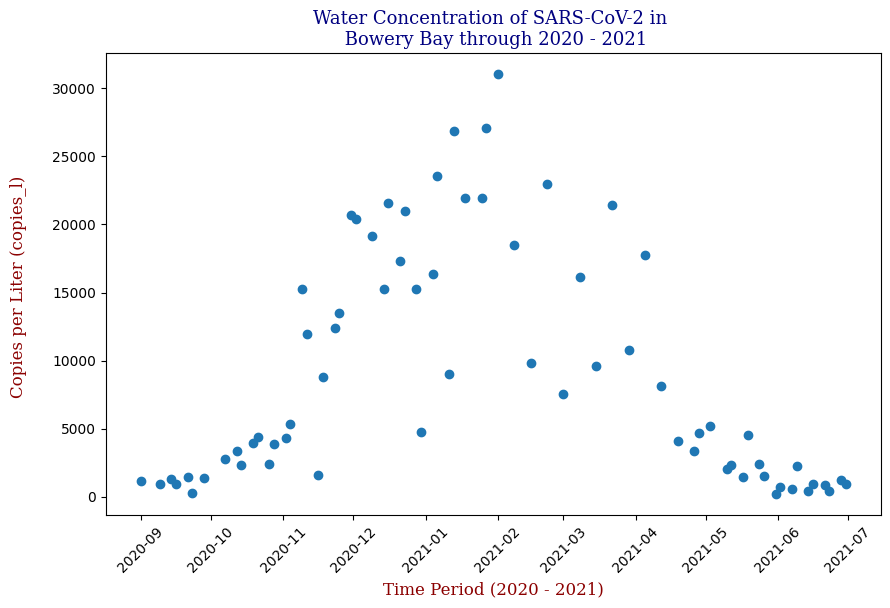

In [32]:
# Let's take a look at our Bowery Bay graph
def bb_graph():
    bb_20_21['test_date'] = pd.to_datetime(bb_20_21['test_date'])
    plt.figure(figsize=(10, 6))
    plt.scatter(bb_20_21.test_date, bb_20_21.copies_l)
    plt.title("Water Concentration of SARS-CoV-2 in \n Bowery Bay through 2020 - 2021", fontdict=font1)
    plt.xlabel('Time Period (2020 - 2021)', fontdict=font2), plt.ylabel('Copies per Liter (copies_l) \n', fontdict=font2)
    # Format x-axis ticks as 'YYYY-MM'
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.show()

bb_graph()

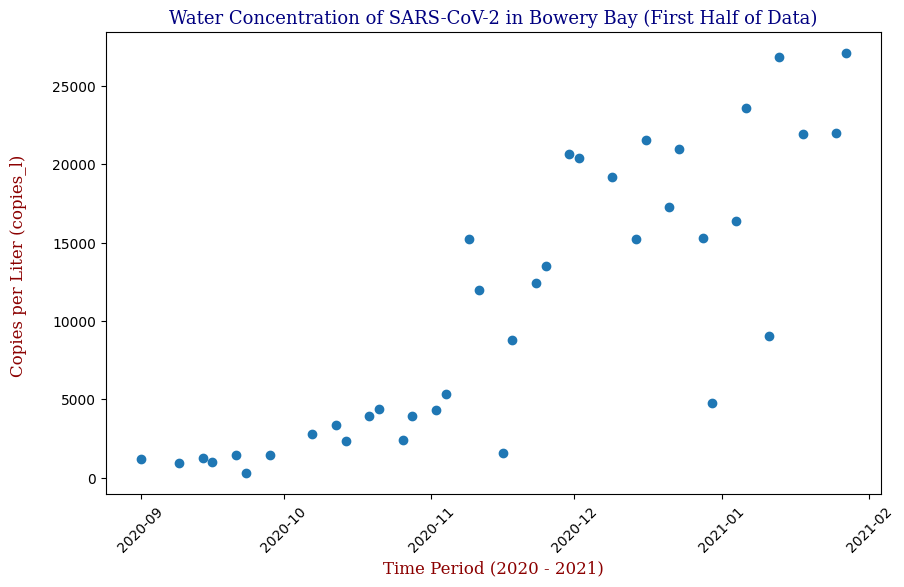

In [34]:
def half_bb_graph():
    # Convert 'test_date' to datetime objects
    bb_20_21['test_date'] = pd.to_datetime(bb_20_21['test_date'])

    # Calculate the middle date
    middle_date = bb_20_21['test_date'].min() + (bb_20_21['test_date'].max() - bb_20_21['test_date'].min()) / 2

    # Filter data to include only dates before the middle date
    df_filtered = bb_20_21[bb_20_21['test_date'] <= middle_date]

    # Create the plot using matplotlib
    plt.figure(figsize=(10, 6))
    plt.scatter(df_filtered['test_date'], df_filtered['copies_l'])
    plt.title("Water Concentration of SARS-CoV-2 in Bowery Bay (First Half of Data)", fontdict=font1)
    plt.xlabel("Time Period (2020 - 2021)", fontdict=font2)
    plt.ylabel("Copies per Liter (copies_l) \n", fontdict=font2)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.show()

half_bb_graph()

### Stochastic Gradient Descent Regression

We will use this graph to apply our linear regression using Stochastic Gradient Descent.

**Data Preparation**

In [38]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Set df equal to 'bb_20_21' which contains 'test_date' and 'copies_l' columns
df = bb_20_21

# Calculate the middle date
middle_date = df['test_date'].min() + (df['test_date'].max() - df['test_date'].min()) / 2

# Filter data to include only dates before the middle date
df_filtered = df[df['test_date'] <= middle_date]

# Prepare data for the filtered DataFrame
X = df_filtered[['test_date']].values
y = df_filtered['copies_l'].values
X = (X - X.min()) / np.timedelta64(1, 'D')  # Convert dates to numerical values

**Automation of Parameter Optimization**

Fine tuning the parameters can be a time consuming, exhaustive process, so let's automate this process using `GridSearchCV`, which systematically tries different combinations of hyperparameter values, evaluates them using cross-validation, and identifies which combination yields the best results.

In [39]:
# Define parameter grid for GridSearchCV, tinkering with the parameters for the SGDRegressor()
param_grid = {
    'loss': ['squared_error', 'huber'],
    'penalty': [None, 'l2', 'l1'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [10000, 50000, 100000], 
    'tol': [1e-3, 1e-4]
}

# Create and train the SGDRegressor model
SGDR = SGDRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=SGDR, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X)

**Model Evaluation**

We will utilize both the Mean Squared Error and R<sup>2</sup> score to validate and measure the accuracy of our model.

In [40]:
# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print results
print("Best parameters found:", best_params)
print(best_model.coef_, best_model.intercept_) # Instead of (SGDR.coef_, SGDR.intercept_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best parameters found: {'alpha': 0.001, 'loss': 'huber', 'max_iter': 50000, 'penalty': None, 'tol': 0.0001}
[150.44904853] [0.88591817]
Mean Squared Error: 22660251.554883607
R-squared: 0.6944886119750969


**Visualization**

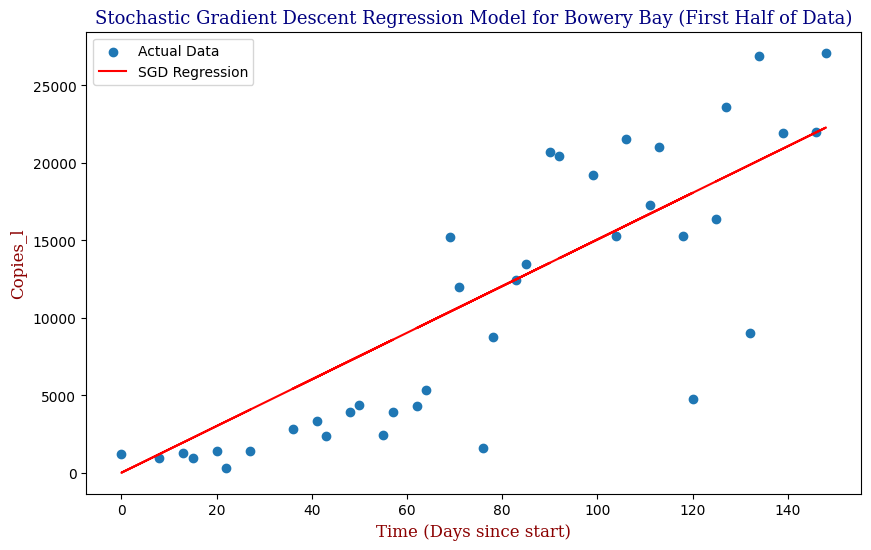

In [41]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Data')
plt.plot(X, y_pred, color='red', label='SGD Regression')
plt.title("Stochastic Gradient Descent Regression Model for Bowery Bay (First Half of Data)", fontdict=font1)
plt.xlabel("Time (Days since start)", fontdict=font2)
plt.ylabel("Copies_l", fontdict=font2)
plt.legend()
plt.show()

While SGD Regression does a decent job predicting the rise of SARS-CoV-2 genetic material in the coming months, it will inadvertently fall short in predicting the full cycle.

Best parameters found: {'alpha': 0.0001, 'loss': 'huber', 'max_iter': 10000, 'penalty': None, 'tol': 0.001}
Mean Squared Error: 116656126.22943166
R-squared: -0.6071179669450648


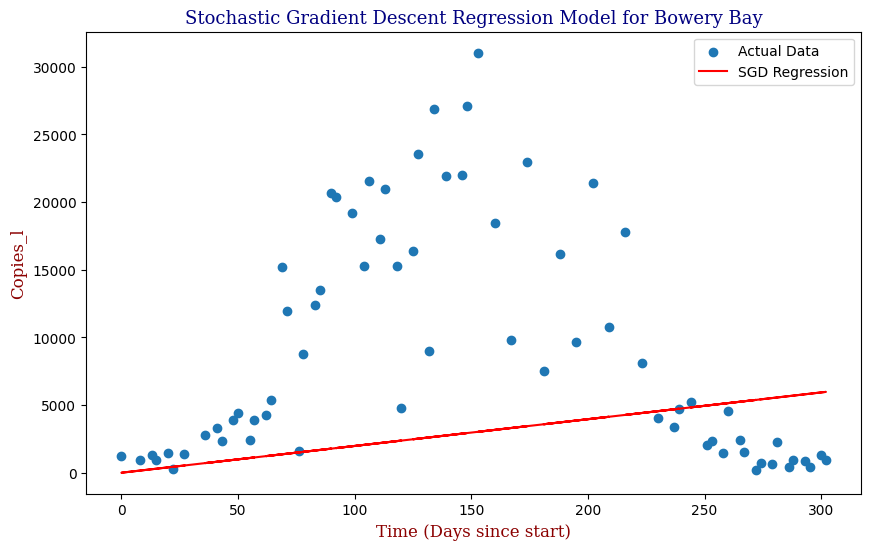

In [43]:
# Prepare data
X = df[['test_date']].values
y = df['copies_l'].values
X = (X - X.min()) / np.timedelta64(1, 'D')  # Convert dates to numerical values

# Define parameter grid for GridSearchCV
param_grid = {
    'loss': ['squared_error', 'huber'],
    'penalty': [None, 'l2', 'l1'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [10000, 50000, 100000], 
    'tol': [1e-3, 1e-4]
}

# Create and train the SGDRegressor model
SGDR = SGDRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=SGDR, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print results
print("Best parameters found:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Data')
plt.plot(X, y_pred, color='red', label='SGD Regression')
plt.title("Stochastic Gradient Descent Regression Model for Bowery Bay", fontdict=font1)
plt.xlabel("Time (Days since start)", fontdict=font2)
plt.ylabel("Copies_l", fontdict=font2)
plt.legend()
plt.show()

We can see that our R<sup>2</sup> score is around -0.6071, which is quite abysmal for a model prediction. We can clearly see the limitations of the SGD regression's predictive ability. For this, we need a better model. Let us explore Polynomial Regression.

### Polynomial Regression

**Data Preparation**

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Calculate the middle date
middle_date = df['test_date'].min() + (df['test_date'].max() - df['test_date'].min()) / 2

# Filter data to include only dates before the middle date
df_filtered = df[df['test_date'] <= middle_date]

# Prepare data for the filtered DataFrame
X = df_filtered[['test_date']].values
y = df_filtered['copies_l'].values
X = (X - X.min()) / np.timedelta64(1, 'D')  # Convert dates to numerical values

**Automation of Parameter Optimization**

In [45]:
# Define parameter grid for GridSearchCV, tinkering with the parameters for PolynomialFeatures() & LinearRegression()
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5],  # Explore a wider range of degrees
    'linearregression__fit_intercept': [True, False]
}

# Create pipeline - which transforms original features to poly features and fits a linear model to poly features
poly_reg = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('linearregression', LinearRegression())
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=poly_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X)

**Model Evaluation**

In [46]:
# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print results
print("Best parameters found:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best parameters found: {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 1}
Mean Squared Error: 20952772.09671553
R-squared: 0.717509292836714


**Visualization**

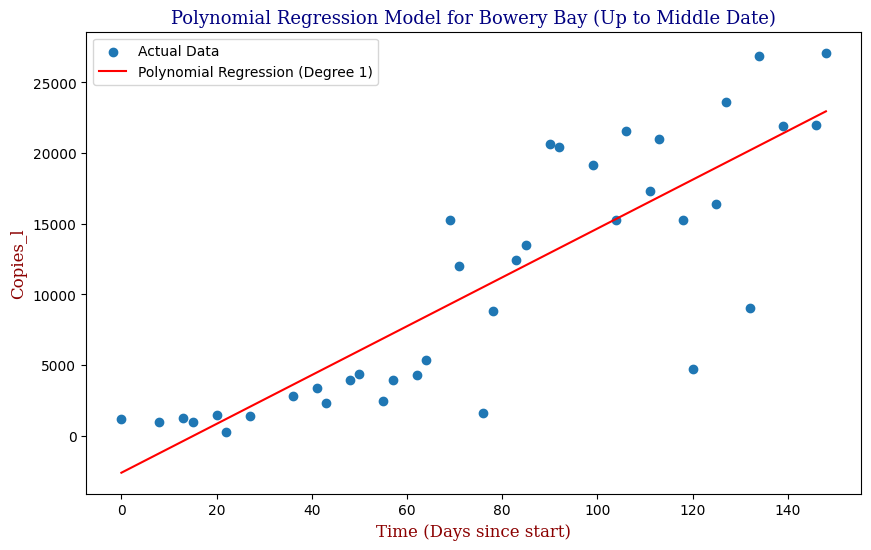

In [47]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Data')

# Generate a smooth curve for plotting
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred_smooth = best_model.predict(X_range)
plt.plot(X_range, y_pred_smooth, color='red', label=f"Polynomial Regression (Degree {best_params['polynomialfeatures__degree']})")

plt.title("Polynomial Regression Model for Bowery Bay (Up to Middle Date)", fontdict=font1)
plt.xlabel("Time (Days since start)", fontdict=font2)
plt.ylabel("Copies_l", fontdict=font2)
plt.legend()
plt.show()

We can see that the R<sup>2</sup> score is slightly better than the SGD Regression, boasting around a 0.7175 score. Finally, let's apply a polynomial regression to the full time period.

**Full Data**

Best parameters found: {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 5}
Mean Squared Error: 18196891.45695544
R-squared: 0.7493097692485865


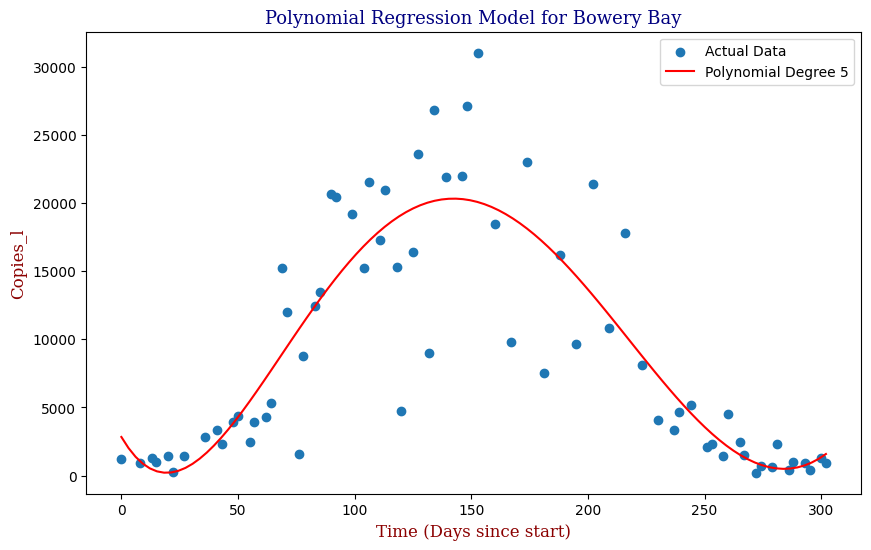

In [59]:
# Prepare data
X = df[['test_date']].values
y = df['copies_l'].values
X = (X - X.min()) / np.timedelta64(1, 'D')  # Convert dates to numerical values

# Define parameter grid for GridSearchCV
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5],  # Explore a wider range of degrees
    'linearregression__fit_intercept': [True, False]
}

# Create pipeline 
poly_reg = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('linearregression', LinearRegression())
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=poly_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X, y)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print results
print("Best parameters found:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Data')

# Generate a smooth curve for plotting
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
# Use X_range, not X_poly_best, as input to predict
y_pred_best = best_model.predict(X_range)
plt.plot(X_range, y_pred_best, color='red', label=f"Polynomial Degree {best_params['polynomialfeatures__degree']}")

plt.title("Polynomial Regression Model for Bowery Bay", fontdict=font1)
plt.xlabel("Time (Days since start)", fontdict=font2)
plt.ylabel("Copies_l", fontdict=font2)
plt.legend()
plt.show()

**Regularization & Normalization**

In the above regression, we have a promising R<sup>2</sup> score of 0.7493. Let's be mindful that the higher we go in degrees, the more susceptible we are to overfitting. Let's incorporate L2 (ridge) penalties into our code, along with `StandardScaler` to preprocess and normalize the data.

Ridge Regression can be expressed as follows:

$ Penalty term=λ\sum_{i=1}^{n}w_{i}^{2}$

where:

- $w_{i}$ is the weight of the $i^{th}$ feature.
- $λ$ is the regularization parameter controlling the amount of regularization.

Best parameters found: {'polynomialfeatures__degree': 5, 'ridge__alpha': 0.1, 'ridge__max_iter': 5000}
Mean Squared Error: 18215929.828180835
R-squared: 0.7490474863368641


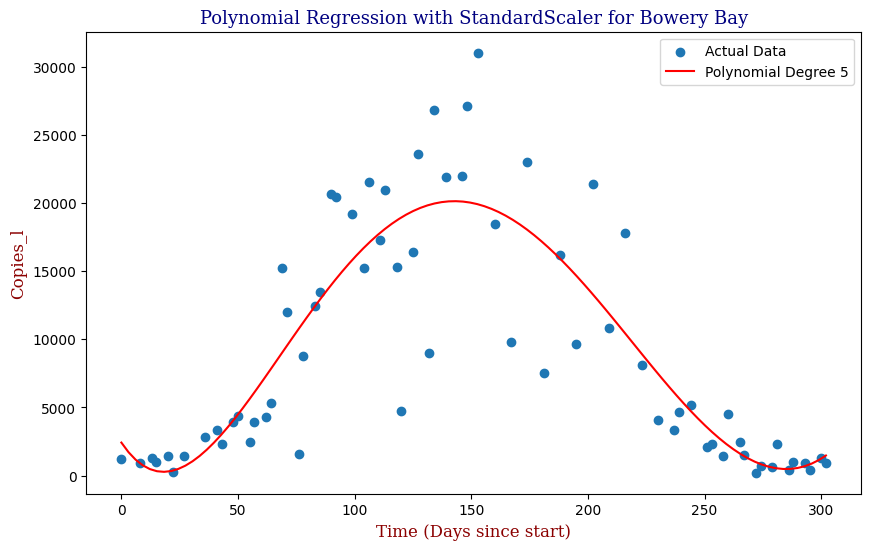

In [61]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Prepare data
X = df[['test_date']].values
y = df['copies_l'].values
X = (X - X.min()) / np.timedelta64(1, 'D')  # Convert dates to numerical values

# Create pipeline with StandardScaler and Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures()),
    ('ridge', Ridge())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': [0.1, 1, 10, 100],
    'ridge__max_iter': [5000, 10000, 20000]
}

# Perform GridSearchCV 
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X, y)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print results
print("Best parameters found:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Data')
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred_best = best_model.predict(X_range)
plt.plot(X_range, y_pred_best, color='red', label=f"Polynomial Degree {best_params['polynomialfeatures__degree']}")
plt.title(f"Polynomial Regression with StandardScaler for Bowery Bay", fontdict=font1)
plt.xlabel("Time (Days since start)", fontdict=font2)
plt.ylabel("Copies_l", fontdict=font2)
plt.legend()
plt.show()

We actually get a slightly less accurate result here, with an R<sup>2</sup> score of approximately 0.7490.

**Polynomial Regression for all 14 Wastewater Resource Recovery Facility (WRRF) Testing Sites**

In [67]:
# Attempt to optimize and apply this regression to all 14 locations. 

def optimize_and_plot_polynomial_regression(location_dataframes, independent_var, 
                                           dependent_var, max_degree=5, scaler=None):
    """
    Optimizes and plots polynomial regression for multiple locations 
    with optional scaling.

    Parameters:
    location_dataframes (dict): Dictionary of DataFrames for each location.
    independent_var (str): Name of the independent variable column.
    dependent_var (str): Name of the dependent variable column.
    max_degree (int, optional): Maximum polynomial degree to consider. Defaults to 4.
    scaler (str, optional): Type of scaler to use ('StandardScaler' or None).
          Defaults to None (no scaling).

    Returns:
    - results (pd.DataFrame): DataFrame containing the MSE and R-squared scores for each location.
    """
    
    results = [] # initialize a list to store the results
    # Define a list of colors for plotting different locations
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Use enumerate to also get the index for color selection
    for i, (wrrf_name, df) in enumerate(location_dataframes.items()): # Iterate using wrrf_name
        # Prepare data
        X = df[[independent_var]].values
        y = df[dependent_var].values
        X = (X - X.min()) / np.timedelta64(1, 'D')  # Convert dates to numerical values

        # Create pipeline with optional scaling
        if scaler == 'StandardScaler':
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=max_degree)),
                ('ridge', Ridge())
            ])
        else:
            pipeline = Pipeline([
                ('poly', PolynomialFeatures(degree=max_degree)),
                ('ridge', Ridge())
            ])

        # Define parameter grid for GridSearchCV
        param_grid = {
            'poly__degree': list(range(1, max_degree + 1)),
            'ridge__alpha': [0.1, 1, 10, 100]
        }

        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                                   scoring='neg_mean_squared_error', cv=10)
        grid_search.fit(X, y)

        # Get best parameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        # Predict using the best model
        y_pred = best_model.predict(X)

        # Evaluate the model
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        # Append results for the current location to the list
        results.append({'wrrf_name': wrrf_name, 'best_degree': best_params['poly__degree'], 
                        'mse': mse, 'r2_score': r2})

        # Plot the results using wrrf_name
        plt.figure(figsize=(10, 6))
        # Access the index i here for consistent color selection
        plt.scatter(X, y, color=colors[i % len(colors)], label='Actual Data')
        X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_pred_smooth = best_model.predict(X_range)
        plt.plot(X_range, y_pred_smooth, color='red', label=f"Polynomial Regression (Degree {best_params['poly__degree']})")
        plt.title(f"Polynomial Regression for {wrrf_name} with {scaler if scaler else 'No'} Scaling", fontdict=font1)
        plt.xlabel("Time (Days since start)", fontdict=font2)
        plt.ylabel(dependent_var, fontdict=font2)
        plt.legend()
        plt.show()

    # Return the results as a Pandas DataFrame
    res = pd.DataFrame(results)
    print(res)
    print('\n' + 'Average MSE score: ' + str(res['mse'].mean()))
    print('\n' + 'Average R-squared score: ' + str(res['r2_score'].mean()))
    return res

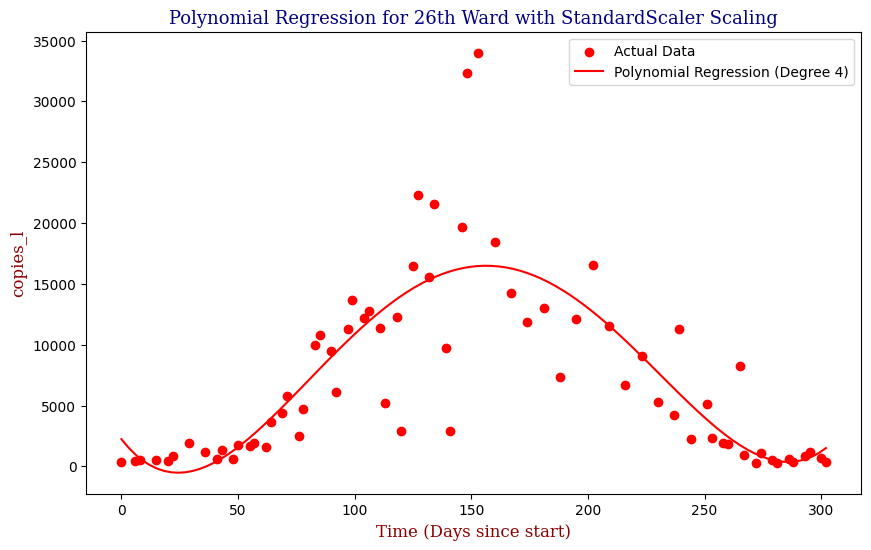

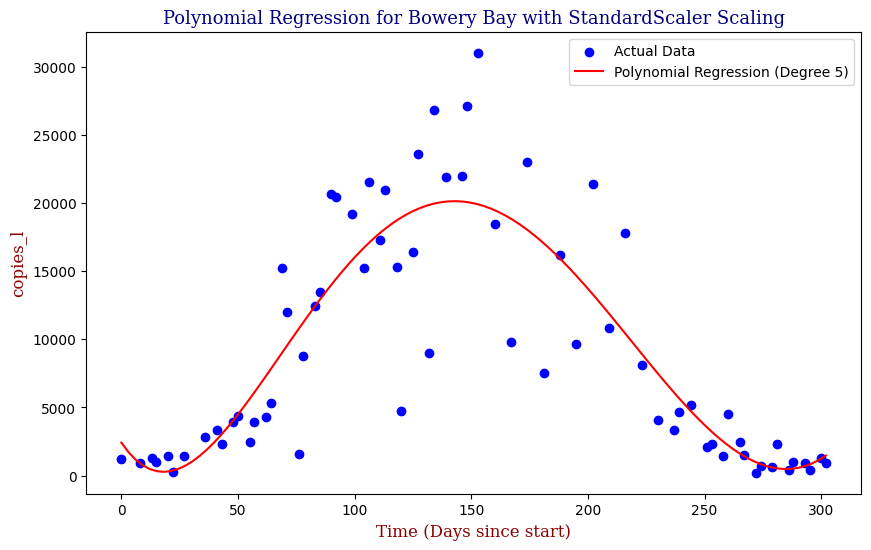

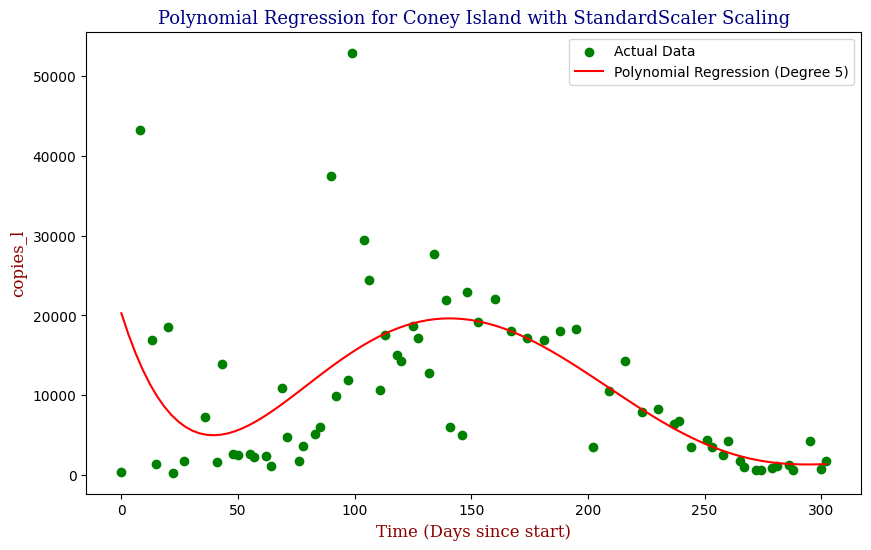

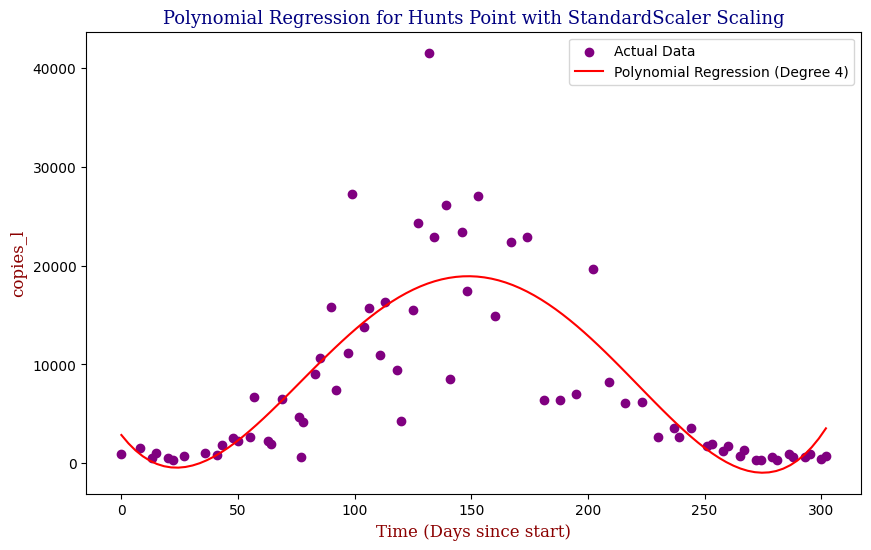

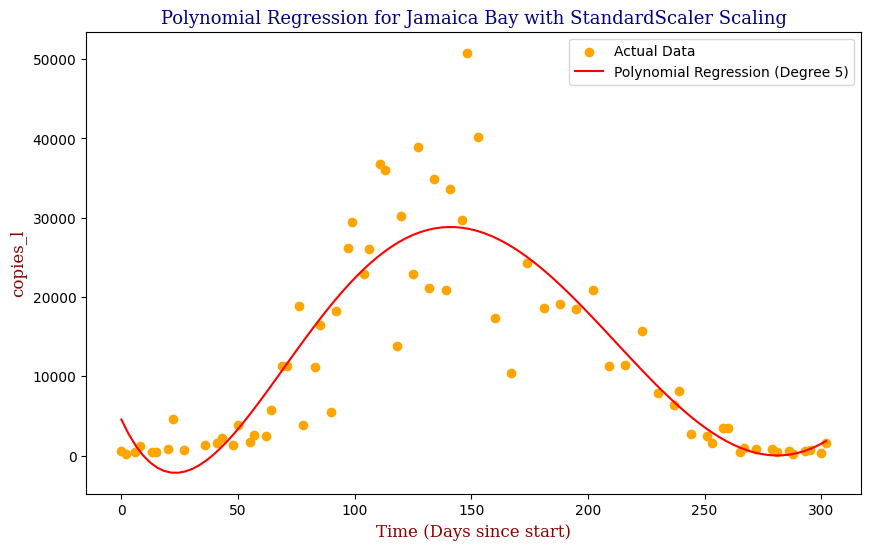

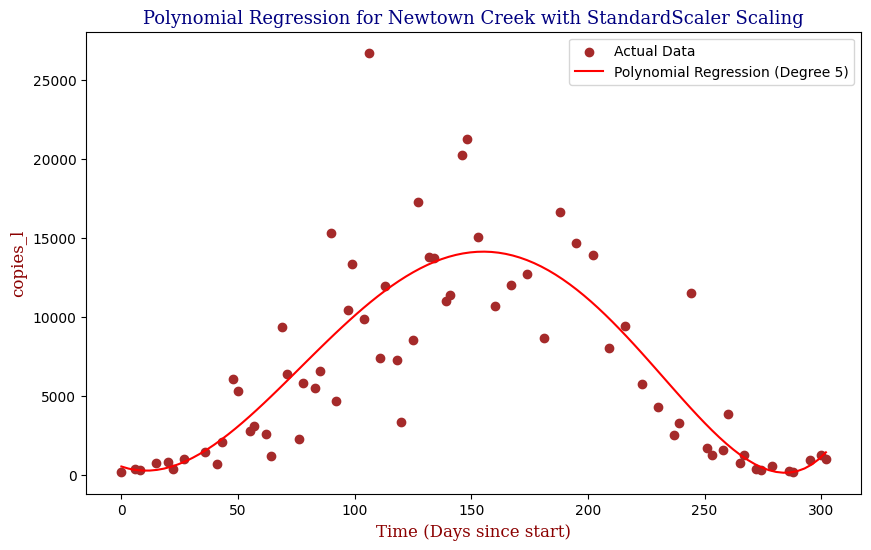

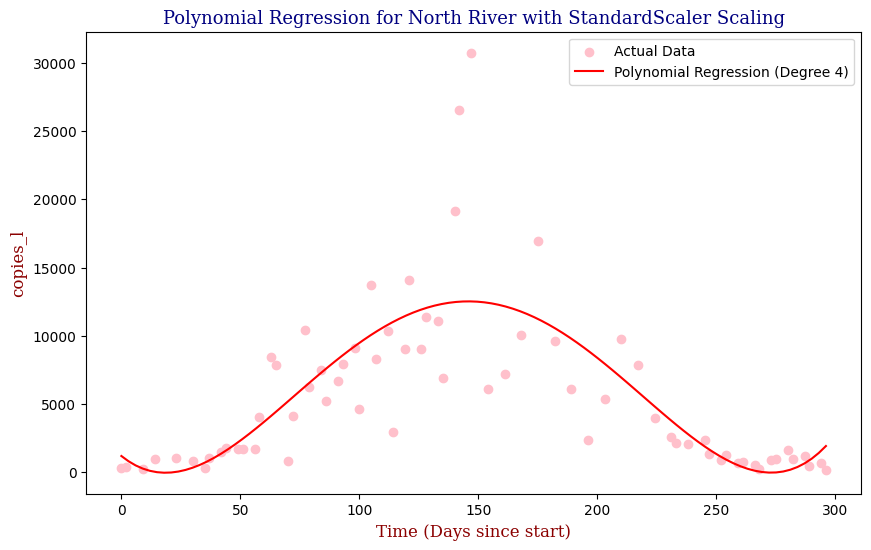

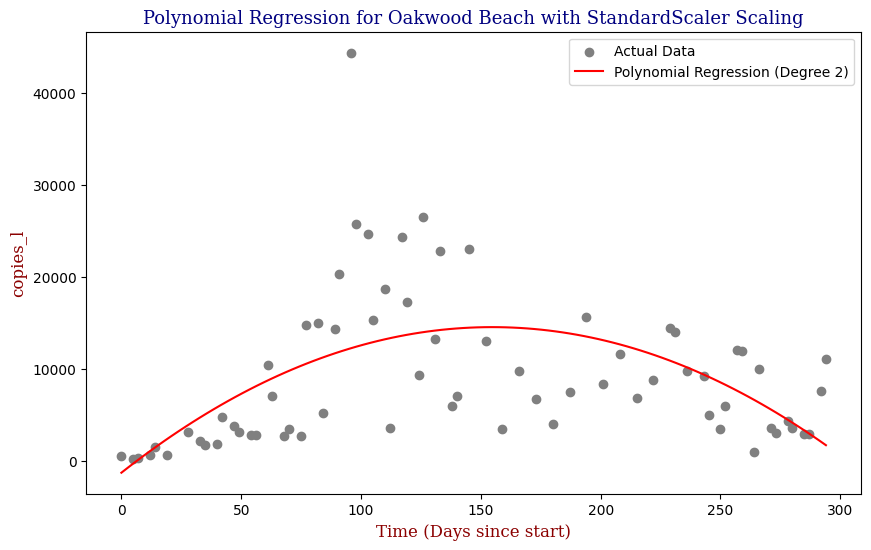

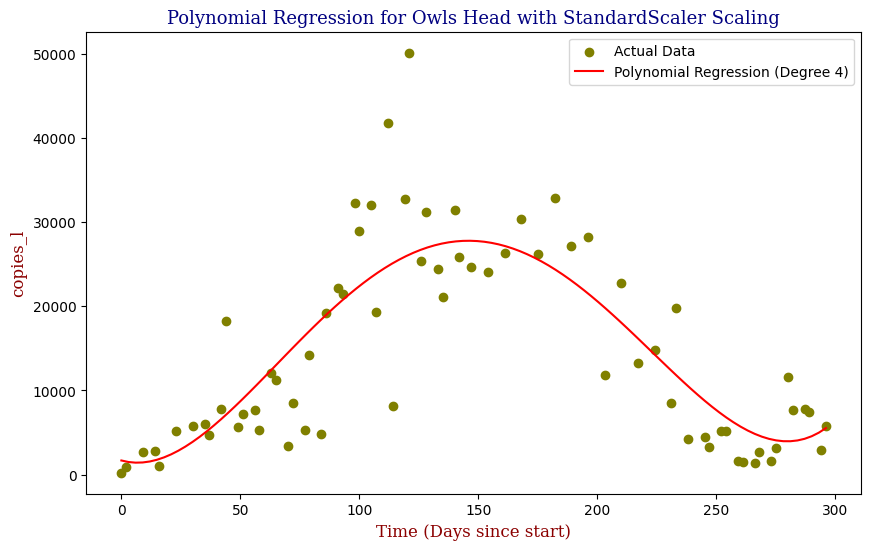

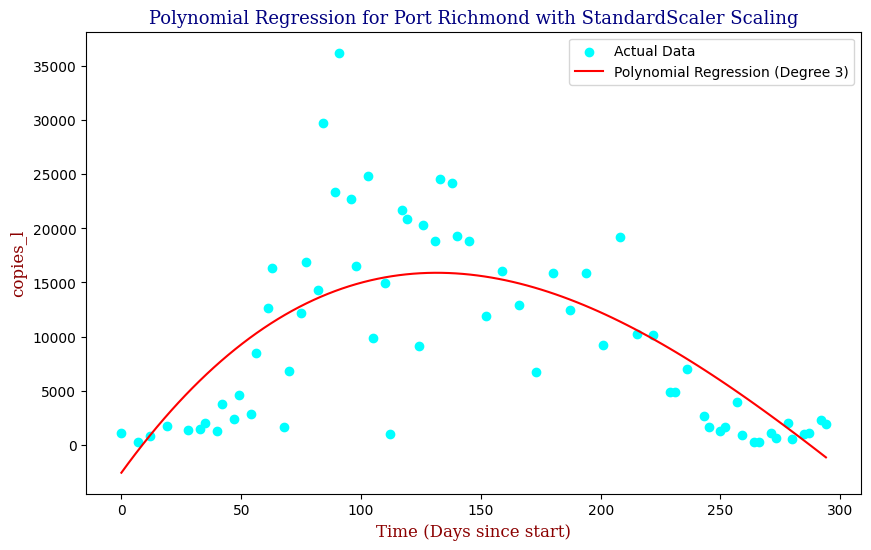

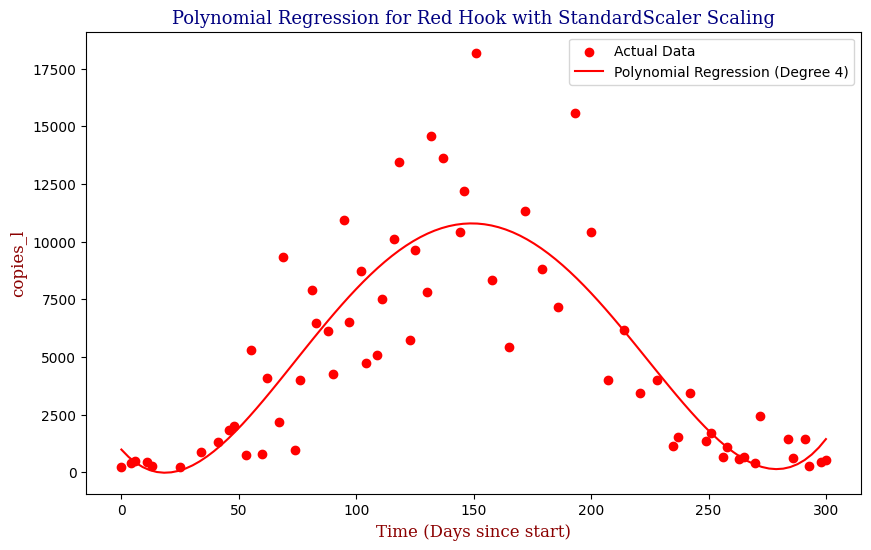

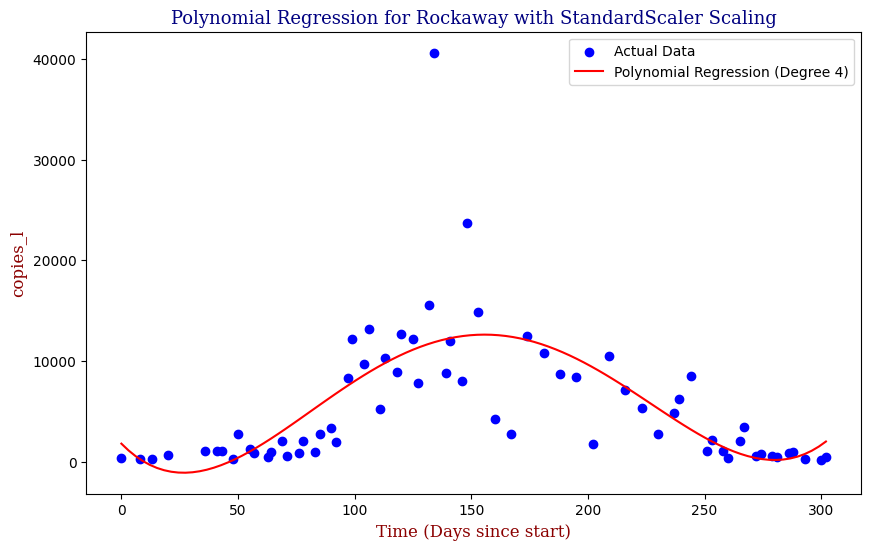

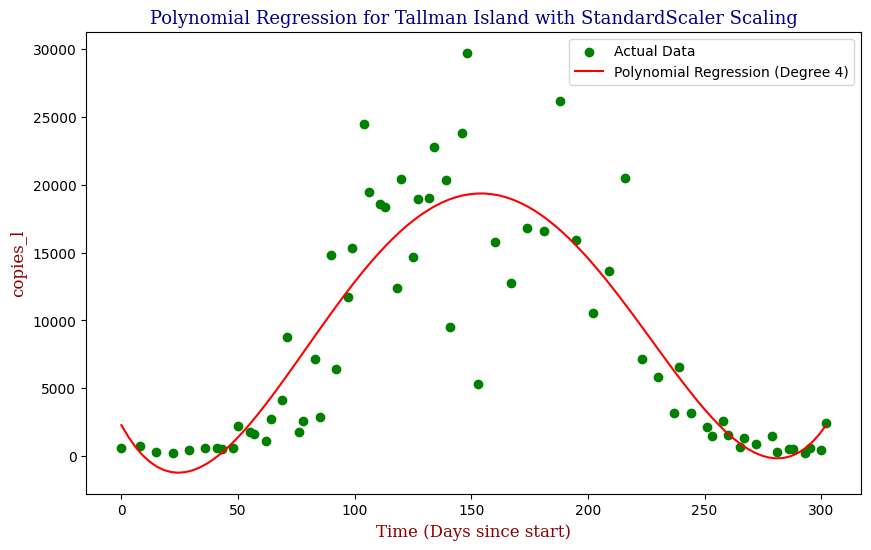

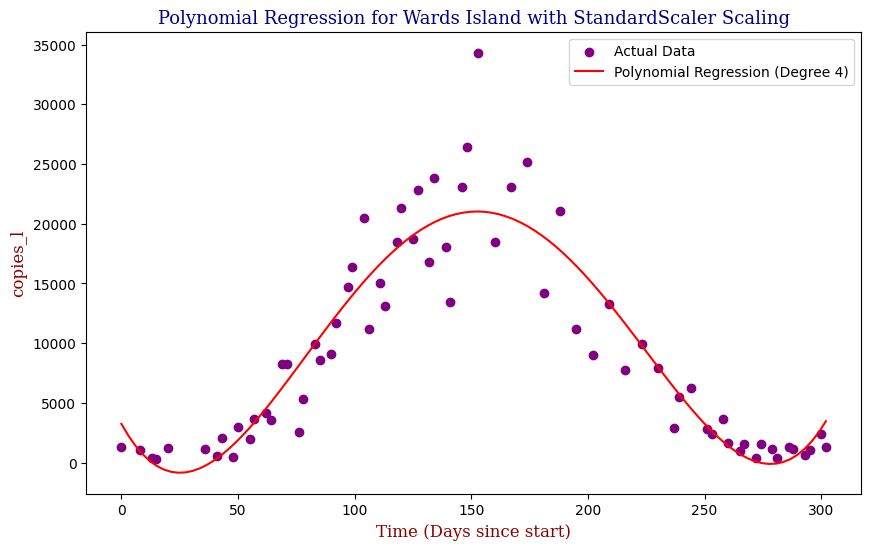

         wrrf_name  best_degree           mse  r2_score
0        26th Ward            4  1.904517e+07  0.656111
1       Bowery Bay            5  1.821593e+07  0.749047
2     Coney Island            5  7.179165e+07  0.366985
3      Hunts Point            4  2.623145e+07  0.666644
4      Jamaica Bay            5  3.385457e+07  0.786260
5    Newtown Creek            5  1.199273e+07  0.679206
6      North River            4  1.460849e+07  0.591942
7    Oakwood Beach            2  4.543060e+07  0.311155
8        Owls Head            4  4.007671e+07  0.705967
9    Port Richmond            3  3.352542e+07  0.566304
10        Red Hook            4  5.544685e+06  0.730302
11        Rockaway            4  2.206931e+07  0.498929
12  Tallman Island            4  1.619646e+07  0.765252
13    Wards Island            4  9.358533e+06  0.866843

Average MSE score: 26281551.264111485

Average R-squared score: 0.6386391311257044


In [68]:
ldf = {
    '26th Ward': w26_20_21, 'Bowery Bay': bb_20_21, 'Coney Island': ci_20_21, 'Hunts Point': hp_20_21, 'Jamaica Bay': ja_20_21, 
    'Newtown Creek': nc_20_21, 'North River': nr_20_21,'Oakwood Beach': ob_20_21, 'Owls Head': oh_20_21, 'Port Richmond': pr_20_21, 
    'Red Hook': rh_20_21, 'Rockaway': rk_20_21, 'Tallman Island': ti_20_21, 'Wards Island': wi_20_21
}

results_df = optimize_and_plot_polynomial_regression(ldf, 'test_date', 'copies_l', scaler='StandardScaler')

Here we can see the Polynomial Regression model, regularized by L2 Ridge and Standard Scaler preprocessing. While the regression scores vary, the mean MSE is approximately 26281551.2641 and the R<sup>2</sup> score is approximately 0.6386, which is poor. 

For the rigid standards of health data and acceptability, the following graded scale can be used to evaluate the model performance.

| **Metric**        | **Excellent** |   **Good**  | **Acceptable** |  **Poor** | **Very Poor** |
|-------------------|:-------------:|:-----------:|:--------------:|:---------:|:-------------:|
| _R<sup>2</sup>_ |     > 0.95    |  0.9 - 0.95 |    0.8 - 0.9   | 0.7 - 0.8 |     < 0.7     |

While in general we want to include the evaluation of our Mean Squared Error into our grading scale for what is acceptable, based on the sheer variability of RNA copies by the order of tens of thousands, it would perhaps be best to consider the variability on a relative, contextual scale, and rely moreso on our R<sup>2</sup> score to determine accuracy.


In order to increase the accuracy of our parameters, we could automate the selection of L1 or L2 regularization and compare the scores of the `StandardScaler`, `MinMaxScaler`, and `RobustScaler` Normalization techniques; however running this function would take significantly longer. We can also try to find an in between utilizing `RandomizedSearchCV`, however we may in turn end up sacrificing accuracy. We can explore additional regression models, such as Support Vector Regression `SVR` with a non-linear kernel (polynomial, radical basis function, sigmoid), `RandomForestsRegressor`, `DecisionTreeRegressor`, or `XGBRegressor` for the locations where our results are still poor, which I would identify as under 65%, and compare them with the current models we are utilizing.

## Conclusion
---

Let's recap what we discovered.


1.   Based off our visualizations, we can see that from the beginning Fall of 2020 to the end of Spring 2021 saw a significant increase of SARS-CoV-2 concentrations in wastewater in Bowery Bay during the winter months, which came back down towards spring heading into summer.
2.   The subsequent rise and fall of SARS-CoV-2 concentrations are reflected in all testing locations throughout NYC, with varying levels.
3.   From our Stochastic Gradient Descent Regression model, we were able to predict the first half of the time period with a Mean Squared Error of **22660251.5549** and an R<sup>2</sup> score of **0.6945**. For the full data, our SGD model performed poorly, with a Mean Squared Error score of **116656126.2294** and an R<sup>2</sup> score of **-0.6071**.
4.   From our Polynomial Regression model, we were able to improve upon the accuracy of our initial regressor model, predicting the first half of the time period with a Mean Squared Error of **20952772.0967** and an and an R<sup>2</sup> score of **0.7175**. We were also able to predict the entire time period with a Mean Squared Error of **18215929.828180835** and an R<sup>2</sup> score of **0.7490**.
5.   Applying our Polynomial Regression to all 14 WFFR sites gave us a diverse application of Regression lines, with an average MSE of **26281551.2641** and an average R<sup>2</sup> score of **0.6386**.



Both of our models are predicting that the SARS-CoV-2 concentrations in the water in Bowery Bay will steadily increase over time. For our Stochastic Gradient Descent Regression line, we can see that our prediction line is limited to an increase similar to the formula $\ y = mx + b$. We can adjust our model through incorporating more data points as well as changing our coefficient and intercept. Obviously, we know that the COVID-19 rate exponentially increased over time, so we need to adjust our model to make an accurate prediction beyond a steady increase. Our Polynomial Regression took a more nuanced approach, scaling exponentially and more accurately representing the slow, gradual, and then steady increase of genetic copies over time.

These methods of modeling can be applied to all 14 different locations where the genetic material for SARS-CoV-2 was measured in order to create predictions of SARS-CoV-2 concentrations throughout NYC. However as these plots are inherently not straight, baseline linear predictive models will of course not be the best method of modeling a prediction of SARS-CoV-2 data points, unless we apply an extraordinary amount of SGDR best fit lines similarly to how we would when taking derivatives. In this case, this is where the Polynomial Regression tackles the challenge, providing a significantly more accurate prediction. However, while it can be applied to the full period of time unlike the SGD Regressor, we can also see that it doesn't perform the greatest. To improve upon the metrics, we can utilize increase the scope of parameter optimization so as to create a more accurate representation.